## Project Code
By: Ali Khambati, Jackson Joffe, Nimedia Ozinegbe, and Donn Boddie

## Environment setup

In [859]:
# This magic command allows figures to be displayed in the notebook
%matplotlib inline 

# Uncomment this line if you want interactive matplotlib plot ()
# %matplotlib notebook 

# reloads modules automatically before entering the execution of code typed at the IPython prompt
%load_ext autoreload
%autoreload 2

# installing a sentiment analysier
#!pip install vaderSentiment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Package imports

In [860]:
# Import required packages
from datetime import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import csv
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

Global variables and environment

In [861]:
# Display arrays with precision and no scientific notation
np.set_printoptions(precision=4,suppress=True)

# maximimum rows
pd.set_option('display.max_rows', 10)

# set seed
SEED = 24

In [862]:
stock_market = pd.read_csv('Stock_market.csv')
stock_market['Date'] = pd.to_datetime(stock_market['caldt'], format = "%Y%m%d")
stock_market['Value_Weighted_Return_Dist'] = stock_market['vwretd']
stock_market['Value_Weighted_Return_No_Dist'] = stock_market['vwretx']
stock_market['Equal_Weighted_Return_Dist'] = stock_market['ewretd']
stock_market['Equal_Weighted_Return_No_Dist'] = stock_market['ewretx']
stock_market['SP500_Return'] = stock_market['sprtrn']
stock_market.drop(columns = ['caldt', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn'], inplace = True)
stock_market

,Date,Value_Weighted_Return_Dist,Value_Weighted_Return_No_Dist,Equal_Weighted_Return_Dist,Equal_Weighted_Return_No_Dist,SP500_Return
0,2015-01-02,-0.000165,-0.000298,-0.000052,-0.000083,-0.000340
1,2015-01-05,-0.018112,-0.018180,-0.020072,-0.020106,-0.018278
2,2015-01-06,-0.008869,-0.008869,-0.010235,-0.010235,-0.008893
3,2015-01-07,0.012110,0.011801,0.011490,0.011369,0.011630
4,2015-01-08,0.017830,0.017808,0.017961,0.017925,0.017888
...,...,...,...,...,...,...
1253,2019-12-24,-0.000132,-0.000202,0.000243,0.000177,-0.000195
1254,2019-12-26,0.005385,0.005296,0.002328,0.002241,0.005128
1255,2019-12-27,0.000028,-0.000062,-0.000830,-0.001018,0.000034
1256,2019-12-30,-0.005631,-0.005763,-0.004008,-0.004245,-0.005781


In [863]:
stock_prices = pd.read_csv('Stock_prices.csv')
stock_prices['Ticker'] = stock_prices['tic']
stock_prices['Company_Name'] = stock_prices['conm']
stock_prices['Shares_Outstanding'] = stock_prices['cshoc']
stock_prices['Trading_Volume'] = stock_prices['cshtrd']
stock_prices['Close_Price'] = stock_prices['prccd']
stock_prices['Open_Price'] = stock_prices['prcod']
stock_prices['Date'] = pd.to_datetime(stock_prices['datadate'], format = "%Y%m%d")

# feature engineering
stock_prices['daily_return'] = (stock_prices['Close_Price'] - stock_prices['Open_Price'])/stock_prices['Open_Price']

stock_prices.drop(columns = ['iid', 'tic', 'datadate', 'conm', 'cshoc', 'cshtrd', 'prccd', 'prcod'], inplace = True)
stock_prices

,gvkey,Ticker,Company_Name,Shares_Outstanding,Trading_Volume,Close_Price,Open_Price,Date,daily_return
0,1690,AAPL,APPLE INC,5864840000,53143770,109.33,111.39,2015-01-02,-0.018494
1,1690,AAPL,APPLE INC,5864840000,64210880,106.25,108.29,2015-01-05,-0.018838
2,1690,AAPL,APPLE INC,5864840000,65682250,106.26,106.54,2015-01-06,-0.002628
3,1690,AAPL,APPLE INC,5864840000,39983350,107.75,107.20,2015-01-07,0.005131
4,1690,AAPL,APPLE INC,5864840000,59168760,111.89,109.23,2015-01-08,0.024352
...,...,...,...,...,...,...,...,...,...
7543,184996,TSLA,TESLA INC,180245000,8054720,425.25,418.36,2019-12-24,0.016469
7544,184996,TSLA,TESLA INC,180245000,10630980,430.94,427.91,2019-12-26,0.007081
7545,184996,TSLA,TESLA INC,180245000,9932377,430.38,435.00,2019-12-27,-0.010621
7546,184996,TSLA,TESLA INC,180245000,12576350,414.70,428.79,2019-12-30,-0.032860


In [864]:
company_tweets = pd.read_csv("Company_Tweet.csv")
company_tweets

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL
...,...,...
4336440,1212158772015034369,TSLA
4336441,1212159099632267268,TSLA
4336442,1212159184931717120,TSLA
4336443,1212159838882533376,TSLA


In [865]:
tweets = pd.read_csv("Tweet.csv")
tweets

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
...,...,...,...,...,...,...,...
3717959,1212159765914079234,TEEELAZER,1577836383,That $SPY $SPX puuump in the last hour was the...,1,0,6
3717960,1212159838882533376,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,0,0,1
3717961,1212160015332728833,Commuternyc,1577836443,Patiently Waiting for the no twitter sitter tw...,0,0,5
3717962,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1


In [866]:
# filter tweets with at least ten likes, five comments, or five retweets
tweets_filtered = tweets[(tweets.comment_num >= 10)|(tweets.retweet_num >= 5)|(tweets.comment_num >= 5)]
tweets_filtered.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
25,550453624258965505,WSJ,1420073345,Jeff Bezos lost $7.4 billion in Amazon's worst...,21,139,57
84,550479777006497792,themotleyfool,1420079580,"#FoolFaves2014 Lo, how the mighty have fallen?...",0,7,5
92,550489146624856064,CNBC,1420081814,"Earlier this month, a mysterious glitch caused...",4,18,17
105,550499176422051840,WSJ,1420084206,Jeff Bezos lost $7.4 billion in Amazon's worst...,17,113,57
254,550650235404701697,greatspoke,1420120221,Analyst Report on Top Stock Market Options for...,0,430,3


In [867]:
# function to define the sentiment of a given tweet
def getSentiment(body):
    analyzer = SentimentIntensityAnalyzer()
    
    assert body is not None
    vs = analyzer.polarity_scores(body)
    score = vs['compound']
    
    if (score >= 0.05): 
        return "Positive"
    
    elif (score < 0.05 and score > -0.05):
        return "Neutral"
    
    elif (score <= -0.05):    
        return "Negative"

In [868]:
# compute sentiment for tweets 
tweets_filtered['Sentiment'] = tweets_filtered['body'].apply(lambda x: getSentiment(x))
tweets_filtered.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,Sentiment
25,550453624258965505,WSJ,1420073345,Jeff Bezos lost $7.4 billion in Amazon's worst...,21,139,57,Negative
84,550479777006497792,themotleyfool,1420079580,"#FoolFaves2014 Lo, how the mighty have fallen?...",0,7,5,Negative
92,550489146624856064,CNBC,1420081814,"Earlier this month, a mysterious glitch caused...",4,18,17,Negative
105,550499176422051840,WSJ,1420084206,Jeff Bezos lost $7.4 billion in Amazon's worst...,17,113,57,Negative
254,550650235404701697,greatspoke,1420120221,Analyst Report on Top Stock Market Options for...,0,430,3,Positive


In [869]:
# merging tweets and companies
df = pd.merge(company_tweets, tweets_filtered, on = 'tweet_id', how = 'inner')
# extracting datetime
df["Date"] = pd.to_datetime(df['post_date'], unit ='s').dt.strftime('%Y-%m-%d')
df.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,Sentiment,Date
0,550781053137616896,AAPL,CNBC,1420151410,This is Wall Street's top pick in 2015. Hint: ...,5,37,22,Positive,2015-01-01
1,550779709840445441,AAPL,WSJ,1420151090,"See how tech companies like Apple, Twitter and...",15,223,109,Positive,2015-01-01
2,550777620422729728,AAPL,philiped,1420150592,"New hed, same story: The Apple press goes off ...",7,13,8,Neutral,2015-01-01
3,550752071243141120,AAPL,themotleyfool,1420144500,"We're shocked, shocked! that Samsung might try...",2,10,9,Negative,2015-01-01
4,550749669060407297,AAPL,SeekingAlpha,1420143928,"Long BlackBerry, Short Apple Again In 2015 htt...",0,5,5,Neutral,2015-01-01


In [870]:
# missing values
df.isna().sum()

tweet_id            0
ticker_symbol       0
writer           1163
post_date           0
body                0
comment_num         0
retweet_num         0
like_num            0
Sentiment           0
Date                0
dtype: int64

In [871]:
# duplicates
df.duplicated().sum()

0

In [872]:
def classify(x):
    if x == 'Positive':
        return 1
    elif x == 'Neutral':
        return 0
    elif x == 'Negative':
        return -1
df['sentiment_class'] = df['Sentiment'].apply(classify)

# weighting comments as more popular than retweets, followed by likes
df['popularity'] = df.comment_num*1.5 + df.retweet_num*1.25 + df.like_num*1
df['sentiment_index'] = df.sentiment_class * df.popularity
df.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,Sentiment,Date,sentiment_class,popularity,sentiment_index
0,550781053137616896,AAPL,CNBC,1420151410,This is Wall Street's top pick in 2015. Hint: ...,5,37,22,Positive,2015-01-01,1,75.75,75.75
1,550779709840445441,AAPL,WSJ,1420151090,"See how tech companies like Apple, Twitter and...",15,223,109,Positive,2015-01-01,1,410.25,410.25
2,550777620422729728,AAPL,philiped,1420150592,"New hed, same story: The Apple press goes off ...",7,13,8,Neutral,2015-01-01,0,34.75,0.00
3,550752071243141120,AAPL,themotleyfool,1420144500,"We're shocked, shocked! that Samsung might try...",2,10,9,Negative,2015-01-01,-1,24.50,-24.50
4,550749669060407297,AAPL,SeekingAlpha,1420143928,"Long BlackBerry, Short Apple Again In 2015 htt...",0,5,5,Neutral,2015-01-01,0,11.25,0.00


In [873]:
df_aapl = df[df.ticker_symbol == 'AAPL']
df_amzn = df[df.ticker_symbol == 'AMZN']
df_tsla = df[df.ticker_symbol == 'TSLA']
df_goog = df[df.ticker_symbol == 'GOOG']
df_msft = df[df.ticker_symbol == 'MSFT']

df_aapl_grouped = df_aapl.groupby('Date')['sentiment_index'].mean().reset_index()
df_aapl_grouped['Date_string'] = df_aapl_grouped['Date'].astype(str)
df_amzn_grouped = df_amzn.groupby('Date')['sentiment_index'].mean().reset_index()
df_amzn_grouped['Date_string'] = df_amzn_grouped['Date'].astype(str)
df_tsla_grouped = df_tsla.groupby('Date')['sentiment_index'].mean().reset_index()
df_tsla_grouped['Date_string'] = df_tsla_grouped['Date'].astype(str)
df_goog_grouped = df_goog.groupby('Date')['sentiment_index'].mean().reset_index()
df_goog_grouped['Date_string'] = df_goog_grouped['Date'].astype(str)
df_msft_grouped = df_msft.groupby('Date')['sentiment_index'].mean().reset_index()
df_msft_grouped['Date_string'] = df_msft_grouped['Date'].astype(str)

In [874]:
stock_prices_aapl = stock_prices[stock_prices.Ticker == 'AAPL']
stock_prices_amzn = stock_prices[stock_prices.Ticker == 'AMZN']
stock_prices_tsla = stock_prices[stock_prices.Ticker == 'TSLA']
stock_prices_goog = stock_prices[stock_prices.Ticker == 'GOOG']
stock_prices_msft = stock_prices[stock_prices.Ticker == 'MSFT']

In [875]:
stock_prices['Date_string'] = stock_prices['Date'].astype(str)

df_joined_aapl = pd.merge(df_aapl_grouped, stock_prices_aapl, on = 'Date_string', how = 'right')
df_joined_aapl.drop(columns = ['Date_x', 'Date_y'], inplace = True)
df_joined_aapl['Date'] = pd.to_datetime(df_joined_aapl['Date_string'])
df_joined_amzn = pd.merge(df_amzn_grouped, stock_prices_amzn, on = 'Date_string', how = 'right')
df_joined_amzn.drop(columns = ['Date_x', 'Date_y'], inplace = True)
df_joined_amzn['Date'] = pd.to_datetime(df_joined_amzn['Date_string'])
df_joined_tsla = pd.merge(df_tsla_grouped, stock_prices_tsla, on = 'Date_string', how = 'right')
df_joined_tsla.drop(columns = ['Date_x', 'Date_y'], inplace = True)
df_joined_tsla['Date'] = pd.to_datetime(df_joined_tsla['Date_string'])
df_joined_goog = pd.merge(df_goog_grouped, stock_prices_goog, on = 'Date_string', how = 'right')
df_joined_goog.drop(columns = ['Date_x', 'Date_y'], inplace = True)
df_joined_goog['Date'] = pd.to_datetime(df_joined_goog['Date_string'])
df_joined_msft = pd.merge(df_msft_grouped, stock_prices_msft, on = 'Date_string', how = 'right')
df_joined_msft.drop(columns = ['Date_x', 'Date_y'], inplace = True)
df_joined_msft['Date'] = pd.to_datetime(df_joined_msft['Date_string'])

KeyError: 'Date_string'

In [ ]:
df_joined_aapl.isna().sum()

sentiment_index       10
Date_string            0
gvkey                  0
Ticker                 0
Company_Name           0
Shares_Outstanding     0
Trading_Volume         0
Close_Price            0
Open_Price             0
daily_return           0
Date                   0
dtype: int64

In [ ]:
df_joined_amzn.isna().sum()

sentiment_index       26
Date_string            0
gvkey                  0
Ticker                 0
Company_Name           0
Shares_Outstanding     0
Trading_Volume         0
Close_Price            0
Open_Price             0
daily_return           0
Date                   0
dtype: int64

In [ ]:
df_joined_tsla.isna().sum()

sentiment_index       18
Date_string            0
gvkey                  0
Ticker                 0
Company_Name           0
Shares_Outstanding     0
Trading_Volume         0
Close_Price            0
Open_Price             0
daily_return           0
Date                   0
dtype: int64

In [ ]:
df_joined_goog.isna().sum()

sentiment_index       125
Date_string             0
gvkey                   0
Ticker                  0
Company_Name            0
Shares_Outstanding      0
Trading_Volume          0
Close_Price             0
Open_Price              0
daily_return            0
Date                    0
dtype: int64

In [ ]:
df_joined_msft.isna().sum()

sentiment_index       106
Date_string             0
gvkey                   0
Ticker                  0
Company_Name            0
Shares_Outstanding      0
Trading_Volume          0
Close_Price             0
Open_Price              0
daily_return            0
Date                    0
dtype: int64

In [ ]:
df_joined_aapl.describe()

,sentiment_index,gvkey,Shares_Outstanding,Trading_Volume,Close_Price,Open_Price,daily_return
count,1248.000000,1258.0,1.258000e+03,1.258000e+03,1258.000000,1258.000000,1258.000000
mean,10.881776,1690.0,5.180018e+09,3.573394e+07,154.476530,154.396121,0.000482
std,24.768072,0.0,4.094217e+08,1.780111e+07,44.119603,44.007650,0.012028
min,-216.750000,1690.0,4.443265e+09,1.136205e+07,90.340000,90.000000,-0.066331
25%,0.000000,1690.0,4.829926e+09,2.363775e+07,115.505000,115.800000,-0.006036
50%,7.575000,1690.0,5.213840e+09,3.144708e+07,150.555000,150.375000,0.000807
75%,18.688419,1690.0,5.544583e+09,4.269216e+07,186.002500,186.002500,0.007225
max,203.416667,1690.0,5.866161e+09,1.618825e+08,293.650000,291.120000,0.086961


In [ ]:
df_joined_amzn.describe()

,sentiment_index,gvkey,Shares_Outstanding,Trading_Volume,Close_Price,Open_Price,daily_return
count,1232.000000,1258.0,1.258000e+03,1.258000e+03,1258.000000,1258.000000,1258.000000
mean,16.485181,64768.0,4.793444e+08,4.170365e+06,1115.048060,1115.492513,-0.000110
std,26.766771,0.0,9.693726e+06,2.233437e+06,531.929838,532.505307,0.014265
min,-161.875000,64768.0,4.630060e+08,8.813370e+05,286.950000,286.280000,-0.085615
25%,4.681844,64768.0,4.708420e+08,2.732460e+06,664.792500,665.692500,-0.007232
50%,13.601020,64768.0,4.779750e+08,3.568038e+06,967.895000,971.550000,-0.000044
75%,24.468168,64768.0,4.877410e+08,4.854083e+06,1676.952500,1680.750000,0.007645
max,247.295455,64768.0,4.957970e+08,2.384672e+07,2039.510000,2038.110000,0.074520


In [ ]:
df_joined_tsla.describe()

,sentiment_index,gvkey,Shares_Outstanding,Trading_Volume,Close_Price,Open_Price,daily_return
count,1240.000000,1258.0,1.258000e+03,1.258000e+03,1258.000000,1258.000000,1258.000000
mean,9.619842,184996.0,1.563089e+08,6.582832e+06,268.918835,268.820492,0.000571
std,21.096648,0.0,1.875747e+07,4.138859e+06,56.139787,56.074658,0.022904
min,-177.673077,184996.0,1.253820e+08,7.102770e+05,143.670000,142.320000,-0.081792
25%,0.175179,184996.0,1.320560e+08,3.986982e+06,220.862500,221.967500,-0.013065
50%,8.084375,184996.0,1.642600e+08,5.512534e+06,257.775000,257.615000,0.000480
75%,16.726689,184996.0,1.705930e+08,7.826728e+06,316.677500,316.172500,0.012934
max,241.458333,184996.0,1.802450e+08,3.359729e+07,430.940000,435.000000,0.135137


In [ ]:
df_joined_goog.describe()

,sentiment_index,gvkey,Shares_Outstanding,Trading_Volume,Close_Price,Open_Price,daily_return
count,1133.000000,1258.0,1.258000e+03,1.258000e+03,1258.000000,1258.000000,1258.000000
mean,12.594728,160329.0,3.463583e+08,1.697098e+06,913.704452,913.422069,0.000303
std,55.357250,0.0,2.817768e+06,8.436526e+05,230.867623,230.528629,0.011820
min,-609.500000,160329.0,3.393390e+08,3.475180e+05,492.550000,494.650000,-0.057637
25%,-1.333333,160329.0,3.439290e+08,1.205674e+06,729.320000,729.275000,-0.005546
50%,5.500000,160329.0,3.469650e+08,1.478656e+06,929.465000,929.730000,0.000376
75%,18.875000,160329.0,3.489520e+08,1.936381e+06,1115.205000,1112.660000,0.007277
max,682.250000,160329.0,3.498830e+08,1.115350e+07,1361.170000,1363.350000,0.052006


In [ ]:
df_joined_msft.describe()

,sentiment_index,gvkey,Shares_Outstanding,Trading_Volume,Close_Price,Open_Price,daily_return
count,1152.000000,1258.0,1.258000e+03,1.258000e+03,1258.000000,1258.000000,1258.000000
mean,12.159293,12141.0,7.799355e+09,2.895746e+07,81.065994,81.051482,0.000422
std,46.346940,0.0,1.680823e+08,1.391669e+07,32.046372,32.073305,0.011469
min,-359.125000,12141.0,7.628806e+09,7.425603e+06,40.290000,40.340000,-0.057615
25%,0.000000,12141.0,7.677000e+09,2.060590e+07,53.517500,53.495000,-0.004860
50%,6.968750,12141.0,7.720515e+09,2.581789e+07,71.010000,70.865000,0.000631
75%,18.781250,12141.0,7.909303e+09,3.324198e+07,106.252500,106.307500,0.006935
max,597.295455,12141.0,8.242853e+09,1.691150e+08,158.960000,159.450000,0.056969


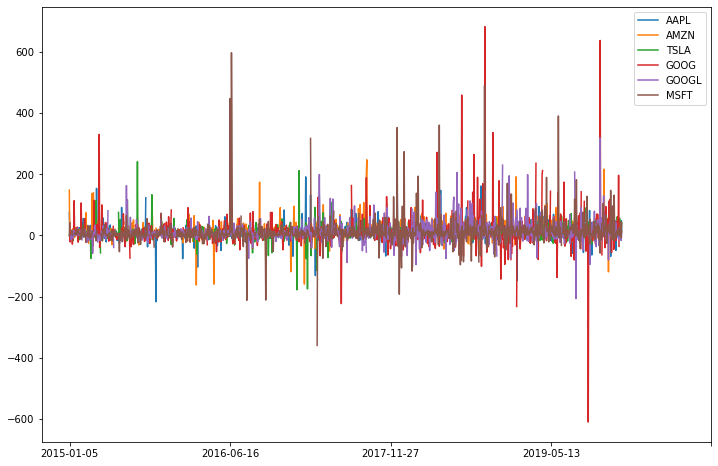

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(12, 8))

xticks = np.arange(1, 1825, 365)

plt.plot(df_joined_aapl.Date_string, df_joined_aapl.sentiment_index, label = "AAPL")
plt.plot(df_joined_amzn.Date_string, df_joined_amzn.sentiment_index, label = "AMZN")
plt.plot(df_joined_tsla.Date_string, df_joined_tsla.sentiment_index, label = "TSLA")
plt.plot(df_joined_goog.Date_string, df_joined_goog.sentiment_index, label = "GOOG")
plt.plot(df_joined_msft.Date_string, df_joined_msft.sentiment_index, label = "MSFT")
plt.xticks(xticks)
plt.legend()
plt.show()

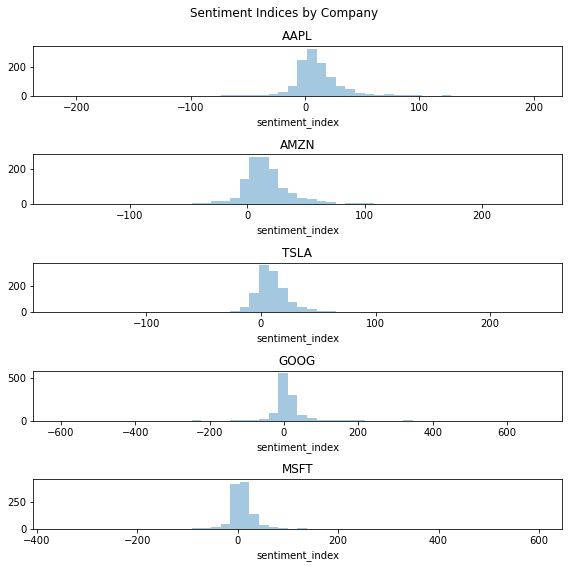

In [ ]:
fig, axs = plt.subplots(5, 1, figsize = (8, 8))
fig.suptitle('Sentiment Indices by Company')
ax1 = sns.distplot(df_joined_aapl.sentiment_index, ax = axs[0],kde=False)
ax1.set_title("AAPL")
ax2 = sns.distplot(df_joined_amzn.sentiment_index, ax = axs[1],kde=False)
ax2.set_title("AMZN")
ax3 = sns.distplot(df_joined_tsla.sentiment_index, ax = axs[2],kde=False)
ax3.set_title("TSLA")
ax4 = sns.distplot(df_joined_goog.sentiment_index, ax = axs[3], kde=False)
ax4.set_title("GOOG")
ax5 = sns.distplot(df_joined_msft.sentiment_index, ax = axs[4], kde = False)
ax5.set_title("MSFT")
fig.tight_layout();

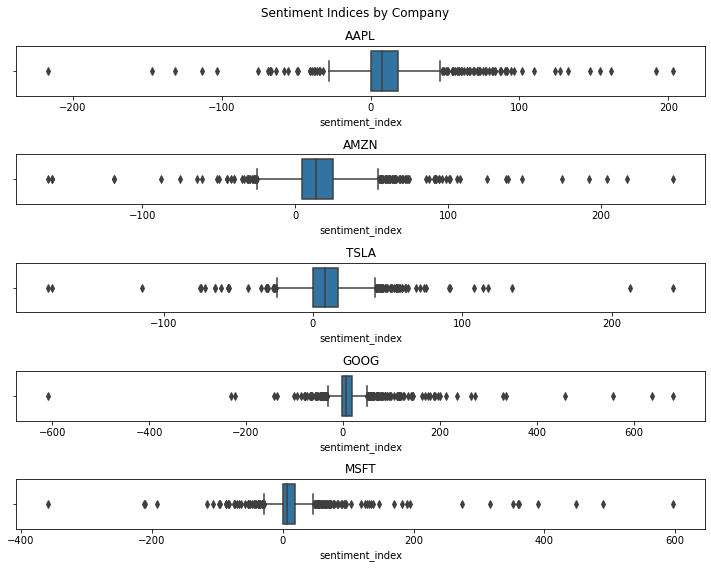

In [ ]:
fig, axs = plt.subplots(5, 1, figsize = (10, 8))
fig.suptitle('Sentiment Indices by Company')
ax1 = sns.boxplot(df_joined_aapl.sentiment_index, ax = axs[0])
ax1.set_title("AAPL")
ax2 = sns.boxplot(df_joined_amzn.sentiment_index, ax = axs[1])
ax2.set_title("AMZN")
ax3 = sns.boxplot(df_joined_tsla.sentiment_index, ax = axs[2])
ax3.set_title("TSLA")
ax4 = sns.boxplot(df_joined_goog.sentiment_index, ax = axs[3])
ax4.set_title("GOOG")
ax6 = sns.boxplot(df_joined_msft.sentiment_index, ax = axs[4])
ax6.set_title("MSFT")
fig.tight_layout();

In [ ]:
# correlation of sentiment returns

corr_aapl = [df_joined_aapl.sentiment_index.corr(df_joined_aapl.sentiment_index), df_joined_aapl.sentiment_index.corr(df_joined_amzn.sentiment_index), df_joined_aapl.sentiment_index.corr(df_joined_tsla.sentiment_index), df_joined_aapl.sentiment_index.corr(df_joined_goog.sentiment_index), df_joined_aapl.sentiment_index.corr(df_joined_msft.sentiment_index)]
corr_amzn = [df_joined_amzn.sentiment_index.corr(df_joined_aapl.sentiment_index), df_joined_amzn.sentiment_index.corr(df_joined_amzn.sentiment_index), df_joined_amzn.sentiment_index.corr(df_joined_tsla.sentiment_index), df_joined_amzn.sentiment_index.corr(df_joined_goog.sentiment_index), df_joined_amzn.sentiment_index.corr(df_joined_msft.sentiment_index)]
corr_tsla = [df_joined_tsla.sentiment_index.corr(df_joined_aapl.sentiment_index), df_joined_tsla.sentiment_index.corr(df_joined_amzn.sentiment_index), df_joined_tsla.sentiment_index.corr(df_joined_tsla.sentiment_index), df_joined_tsla.sentiment_index.corr(df_joined_goog.sentiment_index), df_joined_tsla.sentiment_index.corr(df_joined_msft.sentiment_index)]
corr_goog = [df_joined_goog.sentiment_index.corr(df_joined_aapl.sentiment_index), df_joined_goog.sentiment_index.corr(df_joined_amzn.sentiment_index), df_joined_goog.sentiment_index.corr(df_joined_tsla.sentiment_index), df_joined_goog.sentiment_index.corr(df_joined_goog.sentiment_index),df_joined_goog.sentiment_index.corr(df_joined_msft.sentiment_index)]
corr_msft = [df_joined_msft.sentiment_index.corr(df_joined_aapl.sentiment_index), df_joined_msft.sentiment_index.corr(df_joined_amzn.sentiment_index), df_joined_msft.sentiment_index.corr(df_joined_tsla.sentiment_index), df_joined_msft.sentiment_index.corr(df_joined_goog.sentiment_index), df_joined_goog.sentiment_index.corr(df_joined_goog.sentiment_index)]

df = pd.DataFrame((corr_aapl, corr_amzn, corr_tsla, corr_goog, corr_msft)).T
df.columns = ['AAPL', 'AMZN', 'TSLA', 'GOOG', 'MSFT']
df.index = ['AAPL', 'AMZN', 'TSLA', 'GOOG', 'MSFT']
df

,AAPL,AMZN,TSLA,GOOG,MSFT
AAPL,1.000000,0.176234,0.126418,0.061245,0.153431
AMZN,0.176234,1.000000,0.060031,0.165126,0.090680
TSLA,0.126418,0.060031,1.000000,-0.002128,0.038054
GOOG,0.061245,0.165126,-0.002128,1.000000,0.035478
MSFT,0.153431,0.090680,0.038054,0.035478,1.000000


In [ ]:
a_aapl = stock_prices[stock_prices.Ticker == "AAPL"].drop(columns = ['gvkey', 'Ticker', 'Company_Name', 'Shares_Outstanding', 
                                                            'Trading_Volume', 'Open_Price', 'Close_Price', 'Date'])
a_amzn = stock_prices[stock_prices.Ticker == "AMZN"].drop(columns = ['gvkey', 'Ticker', 'Company_Name', 'Shares_Outstanding', 
                                                            'Trading_Volume', 'Open_Price', 'Close_Price', 'Date'])
a_tsla = stock_prices[stock_prices.Ticker == "TSLA"].drop(columns = ['gvkey', 'Ticker', 'Company_Name', 'Shares_Outstanding', 
                                                            'Trading_Volume', 'Open_Price', 'Close_Price', 'Date'])
a_goog = stock_prices[stock_prices.Ticker == "GOOG"].drop(columns = ['gvkey', 'Ticker', 'Company_Name', 'Shares_Outstanding', 
                                                            'Trading_Volume', 'Open_Price', 'Close_Price', 'Date'])
a_msft = stock_prices[stock_prices.Ticker == "MSFT"].drop(columns = ['gvkey', 'Ticker', 'Company_Name', 'Shares_Outstanding', 
                                                            'Trading_Volume', 'Open_Price', 'Close_Price', 'Date'])

In [ ]:
df_aapl_1 = pd.DataFrame(stock_market[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'Date']])
df_aapl_1['sentiment'] = df_joined_aapl['sentiment_index']
df_aapl_1['Date_string'] = df_aapl_1['Date'].astype(str)
df_aapl_1 = pd.merge(df_aapl_1, a_aapl, on = 'Date_string')
df_aapl_1.index = df_aapl_1['Date_string']
df_aapl_1 = df_aapl_1[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment', 'daily_return']]

df_amzn_1 = pd.DataFrame(stock_market[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'Date']])
df_amzn_1['sentiment'] = df_joined_amzn['sentiment_index']
df_amzn_1['Date_string'] = df_amzn_1['Date'].astype(str)
df_amzn_1 = pd.merge(df_amzn_1, a_amzn, on = 'Date_string')
df_amzn_1.index = df_amzn_1['Date_string']
df_amzn_1 = df_amzn_1[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment', 'daily_return']]

df_tsla_1 = pd.DataFrame(stock_market[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'Date']])
df_tsla_1['sentiment'] = df_joined_tsla['sentiment_index']
df_tsla_1['Date_string'] = df_tsla_1['Date'].astype(str)
df_tsla_1 = pd.merge(df_tsla_1, a_tsla, on = 'Date_string')
df_tsla_1.index = df_tsla_1['Date_string']
df_tsla_1 = df_tsla_1[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment', 'daily_return']]

df_goog_1 = pd.DataFrame(stock_market[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'Date']])
df_goog_1['sentiment'] = df_joined_goog['sentiment_index']
df_goog_1['Date_string'] = df_goog_1['Date'].astype(str)
df_goog_1 = pd.merge(df_goog_1, a_goog, on = 'Date_string')
df_goog_1.index = df_goog_1['Date_string']
df_goog_1 = df_goog_1[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment', 'daily_return']]

df_msft_1 = pd.DataFrame(stock_market[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'Date']])
df_msft_1['sentiment'] = df_joined_msft['sentiment_index']
df_msft_1['Date_string'] = df_msft_1['Date'].astype(str)
df_msft_1 = pd.merge(df_msft_1, a_amzn, on = 'Date_string')
df_msft_1.index = df_msft_1['Date_string']
df_msft_1 = df_msft_1[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment', 'daily_return']]

df_aapl_1.dropna(inplace=True)
df_amzn_1.dropna(inplace=True)
df_tsla_1.dropna(inplace=True)
df_goog_1.dropna(inplace=True)
df_msft_1.dropna(inplace=True)

In [ ]:
df_aapl_1[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment', 'daily_return']].corr()

,Value_Weighted_Return_Dist,Equal_Weighted_Return_Dist,SP500_Return,sentiment,daily_return
Value_Weighted_Return_Dist,1.000000,0.972720,0.999861,0.100206,0.512194
Equal_Weighted_Return_Dist,0.972720,1.000000,0.973200,0.083686,0.454129
SP500_Return,0.999861,0.973200,1.000000,0.099576,0.511512
sentiment,0.100206,0.083686,0.099576,1.000000,0.116405
daily_return,0.512194,0.454129,0.511512,0.116405,1.000000


In [ ]:
df_amzn_1[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment', 'daily_return']].corr()

,Value_Weighted_Return_Dist,Equal_Weighted_Return_Dist,SP500_Return,sentiment,daily_return
Value_Weighted_Return_Dist,1.000000,0.972752,0.999861,0.032449,0.530551
Equal_Weighted_Return_Dist,0.972752,1.000000,0.973237,0.034597,0.450007
SP500_Return,0.999861,0.973237,1.000000,0.032875,0.526329
sentiment,0.032449,0.034597,0.032875,1.000000,0.023427
daily_return,0.530551,0.450007,0.526329,0.023427,1.000000


In [ ]:
df_tsla_1[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']].corr()

,Value_Weighted_Return_Dist,Equal_Weighted_Return_Dist,SP500_Return,sentiment
Value_Weighted_Return_Dist,1.000000,0.972678,0.999861,0.001180
Equal_Weighted_Return_Dist,0.972678,1.000000,0.973158,0.000754
SP500_Return,0.999861,0.973158,1.000000,0.001404
sentiment,0.001180,0.000754,0.001404,1.000000


In [ ]:
df_goog_1[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']].corr()

,Value_Weighted_Return_Dist,Equal_Weighted_Return_Dist,SP500_Return,sentiment
Value_Weighted_Return_Dist,1.000000,0.972897,0.999857,-0.020366
Equal_Weighted_Return_Dist,0.972897,1.000000,0.973398,-0.016422
SP500_Return,0.999857,0.973398,1.000000,-0.020826
sentiment,-0.020366,-0.016422,-0.020826,1.000000


In [ ]:
df_msft_1[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']].corr()

,Value_Weighted_Return_Dist,Equal_Weighted_Return_Dist,SP500_Return,sentiment
Value_Weighted_Return_Dist,1.000000,0.971881,0.999862,0.022365
Equal_Weighted_Return_Dist,0.971881,1.000000,0.972403,0.013707
SP500_Return,0.999862,0.972403,1.000000,0.022644
sentiment,0.022365,0.013707,0.022644,1.000000


In [ ]:
df_1 = a_aapl.merge(a_amzn, on = 'Date_string')
df_1.columns = ['AAPL', 'Date_string','AMZN']

df_2 = df_1.merge(a_tsla, on = 'Date_string')
df_2.columns = ['AAPL', 'Date_string','AMZN', 'TSLA']

df_3 = df_2.merge(a_goog, on = 'Date_string')
df_3.columns = ['AAPL', 'Date_string','AMZN', 'TSLA', 'GOOG']

returns_df = df_3.merge(a_msft, on = 'Date_string')
returns_df.drop(columns = ['Date_string'], inplace=True)
returns_df.columns = ['AAPL', 'AMZN', 'TSLA', 'GOOG','MSFT']
returns_df

#correlation between returns
returns_df.corr()

,AAPL,AMZN,TSLA,GOOG,MSFT
AAPL,1.000000,0.560770,0.339419,0.577407,0.597573
AMZN,0.560770,1.000000,0.378765,0.733023,0.637437
TSLA,0.339419,0.378765,1.000000,0.371527,0.339567
GOOG,0.577407,0.733023,0.371527,1.000000,0.672002
MSFT,0.597573,0.637437,0.339567,0.672002,1.000000


In [ ]:
# train-test split, with 20% test size
df_train_aapl, df_test_aapl = train_test_split(df_aapl_1, test_size = 0.2, random_state = SEED)
df_train_amzn, df_test_amzn = train_test_split(df_amzn_1, test_size = 0.2, random_state = SEED)
df_train_tsla, df_test_tsla = train_test_split(df_tsla_1, test_size = 0.2, random_state = SEED)
df_train_goog, df_test_goog = train_test_split(df_goog_1, test_size = 0.2, random_state = SEED)
df_train_msft, df_test_msft = train_test_split(df_msft_1, test_size = 0.2, random_state = SEED)

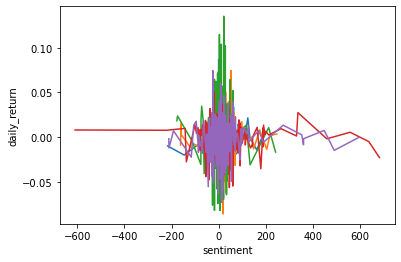

In [ ]:
sns.lineplot(x = df_train_aapl['sentiment'], y = df_train_aapl['daily_return'])
sns.lineplot(x = df_train_amzn['sentiment'], y = df_train_amzn['daily_return'])
sns.lineplot(x = df_train_tsla['sentiment'], y = df_train_tsla['daily_return'])
sns.lineplot(x = df_train_goog['sentiment'], y = df_train_goog['daily_return'])
sns.lineplot(x = df_train_msft['sentiment'], y = df_train_msft['daily_return']);

Two sample T-Tests

In [ ]:
# train sample summary stats
tr_aapl = (
    pd
    .concat((df_train_aapl.mean(), df_train_aapl.std(), df_train_aapl.count()), keys=['tr_avg','tr_sd','tr_n'], axis=1)
    .assign(tr_se = lambda x: x.tr_sd / np.sqrt(x.tr_n))
    .dropna()
)

# test sample summary stats
te_aapl = (
    pd
    .concat((df_test_aapl.mean(), df_test_aapl.std(), df_test_aapl.count()), keys=['te_avg','te_sd','te_n'], axis=1)
    .assign(te_se = lambda x: x.te_sd / np.sqrt(x.te_n))
    .dropna()
)

trte_aapl = (
    pd
    .concat((tr_aapl,te_aapl),axis=1)
    .assign(tdiff = lambda x: (x.tr_avg - x.te_avg) / np.sqrt(x.tr_se**2 + x.te_se**2))
    .loc[:,['tr_avg','te_avg','tdiff']]
)

# Ensure no stat sig diffs
assert (trte_aapl.tdiff < 1.65).all()
trte_aapl

,tr_avg,te_avg,tdiff
Value_Weighted_Return_Dist,0.000576,0.000018,0.902767
Equal_Weighted_Return_Dist,0.000479,0.000109,0.592168
SP500_Return,0.000494,-0.000062,0.900101
sentiment,11.073540,10.116257,0.463730
daily_return,0.000753,-0.000425,1.373501


In [ ]:
# train sample summary stats
tr_amzn = (
    pd
    .concat((df_train_amzn.mean(), df_train_amzn.std(), df_train_amzn.count()), keys=['tr_avg','tr_sd','tr_n'], axis=1)
    .assign(tr_se = lambda x: x.tr_sd / np.sqrt(x.tr_n))
    .dropna()
)

# test sample summary stats
te_amzn = (
    pd
    .concat((df_test_amzn.mean(), df_test_amzn.std(), df_test_amzn.count()), keys=['te_avg','te_sd','te_n'], axis=1)
    .assign(te_se = lambda x: x.te_sd / np.sqrt(x.te_n))
    .dropna()
)

trte_amzn = (
    pd
    .concat((tr_amzn,te_amzn),axis=1)
    .assign(tdiff = lambda x: (x.tr_avg - x.te_avg) / np.sqrt(x.tr_se**2 + x.te_se**2))
    .loc[:,['tr_avg','te_avg','tdiff']]
)

# Ensure no stat sig diffs
assert (trte_amzn.tdiff < 1.65).all()
trte_amzn

,tr_avg,te_avg,tdiff
Value_Weighted_Return_Dist,0.000390,0.000962,-1.045858
Equal_Weighted_Return_Dist,0.000357,0.000775,-0.755021
SP500_Return,0.000313,0.000868,-1.015842
sentiment,16.399362,16.827414,-0.241829
daily_return,-0.000667,0.002403,-3.161865


In [ ]:
# train sample summary stats
tr_tsla = (
    pd
    .concat((df_train_tsla.mean(), df_train_tsla.std(), df_train_tsla.count()), keys=['tr_avg','tr_sd','tr_n'], axis=1)
    .assign(tr_se = lambda x: x.tr_sd / np.sqrt(x.tr_n))
    .dropna()
)

# test sample summary stats
te_tsla = (
    pd
    .concat((df_test_tsla.mean(), df_test_tsla.std(), df_test_tsla.count()), keys=['te_avg','te_sd','te_n'], axis=1)
    .assign(te_se = lambda x: x.te_sd / np.sqrt(x.te_n))
    .dropna()
)

trte_tsla = (
    pd
    .concat((tr_tsla,te_tsla),axis=1)
    .assign(tdiff = lambda x: (x.tr_avg - x.te_avg) / np.sqrt(x.tr_se**2 + x.te_se**2))
    .loc[:,['tr_avg','te_avg','tdiff']]
)

# Ensure no stat sig diffs
assert (trte_tsla.tdiff < 1.65).all()
trte_tsla

,tr_avg,te_avg,tdiff
Value_Weighted_Return_Dist,0.000655,0.000056,1.057037
Equal_Weighted_Return_Dist,0.000626,-0.000098,1.243233
SP500_Return,0.000573,-0.000020,1.045216
sentiment,9.263907,11.043583,-1.226776
daily_return,0.000869,-0.000758,1.071349


In [ ]:
# train sample summary stats
tr_goog = (
    pd
    .concat((df_train_goog.mean(), df_train_goog.std(), df_train_goog.count()), keys=['tr_avg','tr_sd','tr_n'], axis=1)
    .assign(tr_se = lambda x: x.tr_sd / np.sqrt(x.tr_n))
    .dropna()
)

# test sample summary stats
te_goog = (
    pd
    .concat((df_test_goog.mean(), df_test_goog.std(), df_test_goog.count()), keys=['te_avg','te_sd','te_n'], axis=1)
    .assign(te_se = lambda x: x.te_sd / np.sqrt(x.te_n))
    .dropna()
)

trte_goog = (
    pd
    .concat((tr_goog,te_goog),axis=1)
    .assign(tdiff = lambda x: (x.tr_avg - x.te_avg) / np.sqrt(x.tr_se**2 + x.te_se**2))
    .loc[:,['tr_avg','te_avg','tdiff']]
)

# Ensure no stat sig diffs
#assert (trte_goog.tdiff < 1.65).all()
trte_goog

,tr_avg,te_avg,tdiff
Value_Weighted_Return_Dist,0.000786,-0.000348,1.707720
Equal_Weighted_Return_Dist,0.000763,-0.000467,1.833537
SP500_Return,0.000703,-0.000424,1.697035
sentiment,12.580316,12.652251,-0.021007
daily_return,0.000673,-0.000849,1.770369


In [ ]:
# train sample summary stats
tr_msft = (
    pd
    .concat((df_train_msft.mean(), df_train_msft.std(), df_train_msft.count()), keys=['tr_avg','tr_sd','tr_n'], axis=1)
    .assign(tr_se = lambda x: x.tr_sd / np.sqrt(x.tr_n))
    .dropna()
)

# test sample summary stats
te_msft = (
    pd
    .concat((df_test_msft.mean(), df_test_msft.std(), df_test_msft.count()), keys=['te_avg','te_sd','te_n'], axis=1)
    .assign(te_se = lambda x: x.te_sd / np.sqrt(x.te_n))
    .dropna()
)

trte_msft = (
    pd
    .concat((tr_msft,te_msft),axis=1)
    .assign(tdiff = lambda x: (x.tr_avg - x.te_avg) / np.sqrt(x.tr_se**2 + x.te_se**2))
    .loc[:,['tr_avg','te_avg','tdiff']]
)

# Ensure no stat sig diffs
assert (trte_msft.tdiff < 1.65).all()
trte_msft

,tr_avg,te_avg,tdiff
Value_Weighted_Return_Dist,0.000545,0.000319,0.348433
Equal_Weighted_Return_Dist,0.000495,0.000238,0.390793
SP500_Return,0.000462,0.000251,0.326070
sentiment,11.671013,14.106071,-0.678807
daily_return,0.000046,-0.000542,0.542685


In [ ]:
df_train_aapl.describe()

,Value_Weighted_Return_Dist,Equal_Weighted_Return_Dist,SP500_Return,sentiment,daily_return
count,998.000000,998.000000,998.000000,998.000000,998.000000
mean,0.000576,0.000479,0.000494,11.073540,0.000753
std,0.008366,0.008540,0.008372,23.118574,0.012003
min,-0.040869,-0.041088,-0.040979,-216.750000,-0.066331
25%,-0.002815,-0.003444,-0.002855,0.147135,-0.005343
50%,0.000540,0.000544,0.000525,7.948052,0.000988
75%,0.004854,0.005365,0.004687,18.993056,0.007445
max,0.039178,0.033484,0.039034,191.541667,0.086961


In [ ]:
df_train_amzn.describe()

,Value_Weighted_Return_Dist,Equal_Weighted_Return_Dist,SP500_Return,sentiment,daily_return
count,985.000000,985.000000,985.000000,985.000000,985.000000
mean,0.000390,0.000357,0.000313,16.399362,-0.000667
std,0.008737,0.008908,0.008741,27.382499,0.014536
min,-0.040869,-0.041088,-0.040979,-161.875000,-0.085615
25%,-0.002928,-0.003534,-0.002956,4.795455,-0.007359
50%,0.000547,0.000564,0.000509,13.609375,-0.000253
75%,0.004847,0.005338,0.004685,24.535714,0.007382
max,0.049762,0.045981,0.049594,247.295455,0.074520


In [ ]:
df_train_tsla.describe()

,Value_Weighted_Return_Dist,Equal_Weighted_Return_Dist,SP500_Return,sentiment,daily_return
count,992.000000,992.000000,992.000000,992.000000,992.000000
mean,0.000655,0.000626,0.000573,9.263907,0.000869
std,0.008627,0.008748,0.008628,21.307731,0.023519
min,-0.040869,-0.041088,-0.040979,-177.673077,-0.081792
25%,-0.002595,-0.003111,-0.002652,0.222529,-0.012994
50%,0.000528,0.000569,0.000498,8.080357,0.000752
75%,0.004818,0.005252,0.004678,16.253348,0.013152
max,0.049762,0.045981,0.049594,241.458333,0.135137


In [ ]:
df_train_goog.describe()

,Value_Weighted_Return_Dist,Equal_Weighted_Return_Dist,SP500_Return,sentiment,daily_return
count,906.000000,906.000000,906.000000,906.000000,906.000000
mean,0.000786,0.000763,0.000703,12.580316,0.000673
std,0.008350,0.008509,0.008354,58.136121,0.012147
min,-0.040869,-0.041088,-0.040979,-609.500000,-0.057637
25%,-0.002487,-0.003017,-0.002614,-1.492188,-0.005503
50%,0.000642,0.000698,0.000588,5.862500,0.000643
75%,0.004881,0.005377,0.004734,18.869792,0.007810
max,0.049762,0.045981,0.049594,682.250000,0.052006


In [ ]:
df_train_msft.describe()

,Value_Weighted_Return_Dist,Equal_Weighted_Return_Dist,SP500_Return,sentiment,daily_return
count,921.000000,921.000000,921.000000,921.000000,921.000000
mean,0.000545,0.000495,0.000462,11.671013,0.000046
std,0.008268,0.008421,0.008278,45.530510,0.014204
min,-0.039372,-0.041088,-0.039414,-211.625000,-0.072964
25%,-0.002827,-0.003436,-0.002913,0.000000,-0.007288
50%,0.000503,0.000547,0.000489,6.875000,0.000093
75%,0.004787,0.005338,0.004660,18.250000,0.007589
max,0.049762,0.045981,0.049594,597.295455,0.074520


In [ ]:
X_train_aapl = df_train_aapl[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']]
y_train_aapl = df_train_aapl['daily_return']
X_test_aapl = df_test_aapl[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']]
y_test_aapl = df_test_aapl['daily_return']

X_train_amzn = df_train_amzn[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']]
y_train_amzn = df_train_amzn['daily_return']
X_test_amzn = df_test_amzn[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']]
y_test_amzn = df_test_amzn['daily_return']

X_train_tsla = df_train_tsla[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']]
y_train_tsla = df_train_tsla['daily_return']
X_test_tsla = df_test_tsla[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']]
y_test_tsla = df_test_tsla['daily_return']

X_train_goog = df_train_goog[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']]
y_train_goog = df_train_goog['daily_return']
X_test_goog = df_test_goog[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']]
y_test_goog = df_test_goog['daily_return']

X_train_msft = df_train_msft[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']]
y_train_msft = df_train_msft['daily_return']
X_test_msft = df_test_msft[['Value_Weighted_Return_Dist', 'Equal_Weighted_Return_Dist', 'SP500_Return', 'sentiment']]
y_test_msft = df_test_msft['daily_return']

Linear Regression

In [ ]:
# linear model fit for each selected company, all features
def model_fit(X_data, y_data, model, name):
    X_data['const'] = 1
    model_fit = model.fit(X_data, y_data)
    print(f"Model R^2: {name} : {model_fit.score(X_data, y_data)}")
    return model_fit

lin_fit_aapl = model_fit(X_train_aapl, y_train_aapl, LinearRegression(), 'AAPL')
lin_fit_amzn = model_fit(X_train_amzn, y_train_amzn, LinearRegression(), 'AMZN')
lin_fit_tsla = model_fit(X_train_tsla, y_train_tsla, LinearRegression(), 'TSLA')
lin_fit_goog = model_fit(X_train_goog, y_train_goog, LinearRegression(), 'GOOG')
lin_fit_msft = model_fit(X_train_msft, y_train_msft, LinearRegression(), 'MSFT')

Model R^2: AAPL : 0.26742403840358964
Model R^2: AMZN : 0.4243298362662524
Model R^2: TSLA : 0.08076174090145416
Model R^2: GOOG : 0.3885658391869221
Model R^2: MSFT : 0.4374216794754926
Average Linear Regression Model R^2 of Selected Companies: 0.3197006268467422


In [ ]:
import multiprocessing
from sklearn.linear_model import LinearRegression

CPUS = multiprocessing.cpu_count()
folds = KFold(shuffle=True, n_splits=5)

# cross-validation
def cross_val(X_data, y_data, model, name):
    model_fit = cross_val_score(
        model.fit(X_data, y_data),
        X_data,
        y_data,
        cv = folds, 
        scoring = 'r2',
        n_jobs = CPUS - 1
    )
    print(f"CV Scores {name} : {model_fit}")
    print(f"CV Mean Score {name} : {model_fit.mean()})")

cross_val_lin_aapl = cross_val(X_train_aapl, y_train_aapl, LinearRegression(), 'AAPL')
cross_val_lin_amzn = cross_val(X_train_amzn, y_train_amzn, LinearRegression(), 'AMZN')
cross_val_lin_tsla = cross_val(X_train_tsla, y_train_tsla, LinearRegression(), 'TSLA')
cross_val_lin_goog = cross_val(X_train_goog, y_train_goog, LinearRegression(), 'GOOG')
cross_val_lin_msft = cross_val(X_train_msft, y_train_msft, LinearRegression(), 'MSFT')

CV Scores AAPL : [0.3216 0.3184 0.0801 0.1963 0.4036]
CV Mean Score AAPL : 0.2639896801959385)
CV Scores AMZN : [0.3326 0.4023 0.3095 0.4817 0.4098]
CV Mean Score AMZN : 0.38718330458377775)
CV Scores TSLA : [0.1046 0.0881 0.0608 0.0584 0.0521]
CV Mean Score TSLA : 0.07279005358474597)
CV Scores GOOG : [0.228  0.4127 0.2982 0.4724 0.4701]
CV Mean Score GOOG : 0.3762800443075799)
CV Scores MSFT : [0.4263 0.4913 0.4153 0.4208 0.3085]
CV Mean Score MSFT : 0.41246490839911115)


In [ ]:
def rmse_func(X_data, y_data, model):
    model_fit = model.fit(X_data, y_data)
    lin_preds = model_fit.predict(X_data)
    lin_errs = y_data - lin_preds
    rmse = np.sqrt((lin_errs**2).mean())
    print(f'RMSE: {rmse}')
    return model_fit

rmse_aapl = rmse_func(X_train_aapl, y_train_aapl, LinearRegression())
rmse_amzn = rmse_func(X_train_amzn, y_train_amzn, LinearRegression())
rmse_tsla = rmse_func(X_train_tsla, y_train_tsla, LinearRegression())
rmse_goog = rmse_func(X_train_goog, y_train_goog, LinearRegression())
rmse_msft = rmse_func(X_train_msft, y_train_msft, LinearRegression())

RMSE: 0.010268598152662291
RMSE: 0.011023045075730842
RMSE: 0.022537895064012135
RMSE: 0.009492887563731029
RMSE: 0.010648158321896662
Average RMSE: 0.3197006268467422


In [ ]:
def grid_search_cv(X_data, y_data, name, model):
    pgrid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'normalize': [True, False]
    }

    linear_gscv = GridSearchCV(
        model,
        verbose = 1,
        param_grid = pgrid,
        cv = folds,
        refit = False,
        n_jobs= CPUS - 1
    ).fit(X_data, y_data)
    print(f"Tuned Linear Regression {name} : {LinearRegression(linear_gscv.best_params_).fit(X_data, y_data).score(X_data, y_data)}")
    return linear_gscv

lin_gscv_aapl = grid_search_cv(X_train_aapl, y_train_aapl, 'AAPL', LinearRegression())
lin_gscv_amzn = grid_search_cv(X_train_amzn, y_train_amzn, 'AMZN', LinearRegression())
lin_gscv_tsla = grid_search_cv(X_train_tsla, y_train_tsla, 'TSLA', LinearRegression())
lin_gscv_goog = grid_search_cv(X_train_goog, y_train_goog, 'GOOG', LinearRegression())
lin_gscv_msft = grid_search_cv(X_train_msft, y_train_msft, 'MSFT', LinearRegression())

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression AAPL : 0.26742403840358964
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Tuned Linear Regression AMZN : 0.4243298362662524
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression TSLA : 0.08076174090145416
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression GOOG : 0.3885658391869221
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression MSFT : 0.4374216794754926


[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished


In [ ]:
best_lin_fit_aapl = LinearRegression(lin_gscv_aapl.best_params_).fit(X_train_aapl, y_train_aapl)
print(f"Best Linear Model Coefficients: {best_lin_fit_aapl.coef_}")

best_lin_fit_amzn = LinearRegression(lin_gscv_amzn.best_params_).fit(X_train_amzn, y_train_amzn)
print(f"Best Linear Model Coefficients: {best_lin_fit_amzn.coef_}")

best_lin_fit_tsla = LinearRegression(lin_gscv_tsla.best_params_).fit(X_train_tsla, y_train_tsla)
print(f"Best Linear Model Coefficients: {best_lin_fit_tsla.coef_}")

best_lin_fit_goog = LinearRegression(lin_gscv_goog.best_params_).fit(X_train_goog, y_train_goog)
print(f"Best Linear Model Coefficients: {best_lin_fit_goog.coef_}")

best_lin_fit_msft = LinearRegression(lin_gscv_msft.best_params_).fit(X_train_msft, y_train_msft)
print(f"Best Linear Model Coefficients: {best_lin_fit_msft.coef_}")

Best Linear Model Coefficients: [ 2.1157 -1.0082 -0.4256  0.      0.    ]
Best Linear Model Coefficients: [ 26.0443  -1.7896 -23.3629   0.       0.    ]
Best Linear Model Coefficients: [ 11.6158  -0.0236 -10.8385   0.       0.    ]
Best Linear Model Coefficients: [11.4389 -1.619  -9.0456 -0.      0.    ]
Best Linear Model Coefficients: [ 24.1669  -1.97   -21.2652  -0.       0.    ]


Notably, Tesla performs poorly. 

In [ ]:
# ridge fit
ridge_fit_aapl = model_fit(X_train_aapl, y_train_aapl, linear_model.Ridge(alpha = 0), 'AAPL')
ridge_fit_amzn = model_fit(X_train_amzn, y_train_amzn, linear_model.Ridge(alpha = 0), 'AMZN')
ridge_fit_tsla = model_fit(X_train_tsla, y_train_tsla, linear_model.Ridge(alpha = 0), 'TSLA')
ridge_fit_goog = model_fit(X_train_goog, y_train_goog, linear_model.Ridge(alpha = 0), 'GOOG')
ridge_fit_msft = model_fit(X_train_msft, y_train_msft, linear_model.Ridge(alpha = 0), 'MSFT')


rmse_aapl_ridge = rmse_func(X_train_aapl, y_train_aapl, linear_model.Ridge(alpha = 0))
rmse_amzn_ridge = rmse_func(X_train_amzn, y_train_amzn, linear_model.Ridge(alpha = 0))
rmse_tsla_ridge = rmse_func(X_train_tsla, y_train_tsla, linear_model.Ridge(alpha = 0))
rmse_goog_ridge = rmse_func(X_train_goog, y_train_goog, linear_model.Ridge(alpha = 0))
rmse_msft_ridge = rmse_func(X_train_msft, y_train_msft, linear_model.Ridge(alpha = 0))

Model R^2: AAPL : 0.26742403840358975
Model R^2: AMZN : 0.4243298362662523
Model R^2: TSLA : 0.08076174090145438
Model R^2: GOOG : 0.388565839186922
Model R^2: MSFT : 0.4374216794754926
RMSE: 0.010268598152662296
RMSE: 0.01102304507573085
RMSE: 0.02253789506401214
RMSE: 0.009492887563731033
RMSE: 0.01064815832189666
Average Random Forest RMSE: 0.2935554385198633


In [ ]:
# Ridge cross validation
ridge_cv_aapl = cross_val(X_train_aapl, y_train_aapl, linear_model.Ridge(alpha = 0), 'AAPL')
ridge_cv_amzn = cross_val(X_train_amzn, y_train_amzn, linear_model.Ridge(alpha = 0), 'AMZN')
ridge_cv_tsla = cross_val(X_train_tsla, y_train_tsla, linear_model.Ridge(alpha = 0), 'TSLA')
ridge_cv_goog = cross_val(X_train_goog, y_train_goog, linear_model.Ridge(alpha = 0), 'GOOG')
ridge_cv_msft = cross_val(X_train_msft, y_train_msft, linear_model.Ridge(alpha = 0), 'MSFT')

CV Scores AAPL : [-0.039   0.41    0.259   0.3137  0.3644]
CV Mean Score AAPL : 0.2616135940375862)
CV Scores AMZN : [0.4767 0.3255 0.4222 0.3761 0.4412]
CV Mean Score AMZN : 0.40835159060222664)
CV Scores TSLA : [0.0297 0.0978 0.0746 0.0257 0.1139]
CV Mean Score TSLA : 0.06833056126834589)
CV Scores GOOG : [0.3749 0.3986 0.3833 0.282  0.4497]
CV Mean Score GOOG : 0.3776893892454091)
CV Scores MSFT : [0.3523 0.2572 0.4384 0.4773 0.5306]
CV Mean Score MSFT : 0.4111749082709573)


In [ ]:
def randomized_grid_search_cv(X_data, y_data, model, name):
    pgrid = {
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4]
    }

    gscv = RandomizedSearchCV(
        model,
        param_distributions=pgrid,
        cv = folds,
        refit = False,
        random_state=SEED,
        n_iter = 30,
        verbose = 1,
        n_jobs = CPUS - 1
    ).fit(X_data, y_data)
    print(f"Tuned Random Forest Regression {name} : {gscv.best_score_}")
    print(f"Tuned Random Forest Regression Parameters {name}: {gscv.best_params_}")

ridge_gscv_aapl = grid_search_cv(X_train_aapl, y_train_aapl, 'AAPL',linear_model.Ridge(alpha = 0))
ridge_gscv_amzn = grid_search_cv(X_train_amzn, y_train_amzn, 'AMZN',linear_model.Ridge(alpha = 0))
ridge_gscv_tsla = grid_search_cv(X_train_tsla, y_train_tsla, 'TSLA',linear_model.Ridge(alpha = 0))
ridge_gscv_goog = grid_search_cv(X_train_goog, y_train_goog, 'GOOG',linear_model.Ridge(alpha = 0))
ridge_gscv_msft = grid_search_cv(X_train_msft, y_train_msft, 'MSFT',linear_model.Ridge(alpha = 0))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression AAPL : 0.26742403840358964
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished


Tuned Linear Regression AMZN : 0.4243298362662524
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression TSLA : 0.08076174090145416
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression GOOG : 0.3885658391869221
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression MSFT : 0.4374216794754926


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished


In [ ]:
ridge_gscv_aapl.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

In [ ]:
best_ridge_fit_aapl = linear_model.Ridge(alpha = 0, copy_X = True, fit_intercept = True, normalize = True).fit(X_train_aapl, y_train_aapl)
print(f"Best Ridge Model Coefficients: {best_ridge_fit_aapl.coef_}")

best_ridge_fit_amzn = linear_model.Ridge(alpha = 0, copy_X = True, fit_intercept = True, normalize = True).fit(X_train_amzn, y_train_amzn)
print(f"Best Ridge Model Coefficients: {best_ridge_fit_amzn.coef_}")

best_ridge_fit_tsla = linear_model.Ridge(alpha = 0, copy_X = True, fit_intercept = True, normalize = True).fit(X_train_tsla, y_train_tsla)
print(f"Best Ridge Model Coefficients: {best_ridge_fit_tsla.coef_}")

best_ridge_fit_goog = linear_model.Ridge(alpha = 0, copy_X = True, fit_intercept = True, normalize = True).fit(X_train_goog, y_train_goog)
print(f"Best Ridge Model Coefficients: {best_ridge_fit_goog.coef_}")

best_ridge_fit_msft = linear_model.Ridge(alpha = 0, copy_X = True, fit_intercept = True, normalize = True).fit(X_train_msft, y_train_msft)
print(f"Best Ridge Model Coefficients: {best_ridge_fit_msft.coef_}")

Best Ridge Model Coefficients: [ 2.1157 -1.0082 -0.4256  0.      0.    ]
Best Ridge Model Coefficients: [ 26.0443  -1.7896 -23.3629   0.       0.    ]
Best Ridge Model Coefficients: [ 11.6158  -0.0236 -10.8385   0.       0.    ]
Best Ridge Model Coefficients: [11.4389 -1.619  -9.0456 -0.      0.    ]
Best Ridge Model Coefficients: [ 24.1669  -1.97   -21.2652  -0.       0.    ]


In [ ]:
# lasso fit
lasso_fit_aapl = model_fit(X_train_aapl, y_train_aapl, linear_model.Lasso(alpha = 1), 'AAPL')
lasso_fit_amzn = model_fit(X_train_amzn, y_train_amzn, linear_model.Lasso(alpha = 1), 'AMZN')
lasso_fit_tsla = model_fit(X_train_tsla, y_train_tsla, linear_model.Lasso(alpha = 1), 'TSLA')
lasso_fit_goog = model_fit(X_train_goog, y_train_goog, linear_model.Lasso(alpha = 1), 'GOOG')
lasso_fit_msft = model_fit(X_train_msft, y_train_msft, linear_model.Lasso(alpha = 1), 'MSFT')


rmse_aapl_lasso = rmse_func(X_train_aapl, y_train_aapl, linear_model.Lasso(alpha = 1))
rmse_amzn_lasso = rmse_func(X_train_amzn, y_train_amzn, linear_model.Lasso(alpha = 1))
rmse_tsla_lasso = rmse_func(X_train_tsla, y_train_tsla, linear_model.Lasso(alpha = 1))
rmse_goog_lasso = rmse_func(X_train_goog, y_train_goog, linear_model.Lasso(alpha = 1))
rmse_msft_lasso = rmse_func(X_train_msft, y_train_msft, linear_model.Lasso(alpha = 1))

Model R^2: AAPL : 0.0
Model R^2: AMZN : 0.0
Model R^2: TSLA : 0.0
Model R^2: GOOG : 0.0
Model R^2: MSFT : 0.0
RMSE: 0.011997336132475375
RMSE: 0.014528297445134298
RMSE: 0.02350711363305624
RMSE: 0.012140134197121424
RMSE: 0.014196556124288074


In [ ]:
# lasso cross validation
lasso_cv_aapl = cross_val(X_train_aapl, y_train_aapl, linear_model.Lasso(alpha = 1), 'AAPL')
lasso_cv_amzn = cross_val(X_train_amzn, y_train_amzn, linear_model.Lasso(alpha = 1), 'AMZN')
lasso_cv_tsla = cross_val(X_train_tsla, y_train_tsla, linear_model.Lasso(alpha = 1), 'TSLA')
lasso_cv_goog = cross_val(X_train_goog, y_train_goog, linear_model.Lasso(alpha = 1), 'GOOG')
lasso_cv_msft = cross_val(X_train_msft, y_train_msft, linear_model.Lasso(alpha = 1), 'MSFT')

CV Scores AAPL : [-0.0029 -0.0051 -0.0005 -0.0007 -0.0036]
CV Mean Score AAPL : -0.002571517066869378)
CV Scores AMZN : [-0.0001 -0.0025 -0.0028 -0.0179 -0.0159]
CV Mean Score AMZN : -0.007851908988265733)
CV Scores TSLA : [-0.0011 -0.0184 -0.0015 -0.0367 -0.0005]
CV Mean Score TSLA : -0.011631524896901446)
CV Scores GOOG : [-0.0215 -0.0002 -0.0012 -0.0056 -0.0002]
CV Mean Score GOOG : -0.005730260700716761)
CV Scores MSFT : [-0.0098 -0.0055 -0.0068 -0.0324 -0.0059]
CV Mean Score MSFT : -0.012098632089795646)


In [ ]:
lasso_gscv_aapl = grid_search_cv(X_train_aapl, y_train_aapl, 'AAPL',linear_model.Lasso(alpha = 1))
lasso_gscv_amzn = grid_search_cv(X_train_amzn, y_train_amzn, 'AMZN',linear_model.Lasso(alpha = 1))
lasso_gscv_tsla = grid_search_cv(X_train_tsla, y_train_tsla, 'TSLA',linear_model.Lasso(alpha = 1))
lasso_gscv_goog = grid_search_cv(X_train_goog, y_train_goog, 'GOOG',linear_model.Lasso(alpha = 1))
lasso_gscv_msft = grid_search_cv(X_train_msft, y_train_msft, 'MSFT',linear_model.Lasso(alpha = 1))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression AAPL : 0.26742403840358964
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Tuned Linear Regression AMZN : 0.4243298362662524
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression TSLA : 0.08076174090145416
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression GOOG : 0.3885658391869221
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression MSFT : 0.4374216794754926


[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished


In [ ]:
best_lasso_fit_aapl = linear_model.Lasso(alpha = 1, copy_X = True, fit_intercept = True, normalize= True).fit(X_train_aapl, y_train_aapl)
print(f"Best Lasso Model Coefficients: {best_lasso_fit_aapl.coef_}")

best_lasso_fit_amzn = linear_model.Lasso(alpha = 1, copy_X = True, fit_intercept = True, normalize= True).fit(X_train_amzn, y_train_amzn)
print(f"Best Lasso Model Coefficients: {best_lasso_fit_amzn.coef_}")

best_lasso_fit_tsla = linear_model.Lasso(alpha = 1, copy_X = True, fit_intercept = True, normalize= True).fit(X_train_tsla, y_train_tsla)
print(f"Best Lasso Model Coefficients: {best_lasso_fit_tsla.coef_}")

best_lasso_fit_goog = linear_model.Lasso(alpha = 1, copy_X = True, fit_intercept = True, normalize= True).fit(X_train_goog, y_train_goog)
print(f"Best Lasso Model Coefficients: {best_lasso_fit_goog.coef_}")

best_lasso_fit_msft = linear_model.Lasso(alpha = 1, copy_X = True, fit_intercept = True, normalize= True).fit(X_train_msft, y_train_msft)
print(f"Best Lasso Model Coefficients: {best_lasso_fit_msft.coef_}")

Best Lasso Model Coefficients: [0. 0. 0. 0. 0.]
Best Lasso Model Coefficients: [0. 0. 0. 0. 0.]
Best Lasso Model Coefficients: [0. 0. 0. 0. 0.]
Best Lasso Model Coefficients: [ 0.  0.  0. -0.  0.]
Best Lasso Model Coefficients: [ 0.  0.  0. -0.  0.]


In [ ]:
# elastic net fit
el_fit_aapl = model_fit(X_train_aapl, y_train_aapl, linear_model.Lasso(alpha = 0.5), 'AAPL')
el_fit_amzn = model_fit(X_train_amzn, y_train_amzn, linear_model.Lasso(alpha = 0.5), 'AMZN')
el_fit_tsla = model_fit(X_train_tsla, y_train_tsla, linear_model.Lasso(alpha = 0.5), 'TSLA')
el_fit_goog = model_fit(X_train_goog, y_train_goog, linear_model.Lasso(alpha = 0.5), 'GOOG')
el_fit_msft = model_fit(X_train_msft, y_train_msft, linear_model.Lasso(alpha = 0.5), 'MSFT')


rmse_aapl_el = rmse_func(X_train_aapl, y_train_aapl, linear_model.Lasso(alpha = 0.5))
rmse_amzn_el = rmse_func(X_train_amzn, y_train_amzn, linear_model.Lasso(alpha = 0.5))
rmse_tsla_el = rmse_func(X_train_tsla, y_train_tsla, linear_model.Lasso(alpha = 0.5))
rmse_goog_el = rmse_func(X_train_goog, y_train_goog, linear_model.Lasso(alpha = 0.5))
rmse_msft_el = rmse_func(X_train_msft, y_train_msft, linear_model.Lasso(alpha = 0.5))

Model R^2: AAPL : 0.0
Model R^2: AMZN : 0.0
Model R^2: TSLA : 0.0
Model R^2: GOOG : 0.0
Model R^2: MSFT : 0.0
RMSE: 0.011997336132475375
RMSE: 0.014528297445134298
RMSE: 0.02350711363305624
RMSE: 0.012140134197121424
RMSE: 0.014196556124288074


In [ ]:
# lasso cross validation
el_cv_aapl = cross_val(X_train_aapl, y_train_aapl, linear_model.Lasso(alpha = 0.5), 'AAPL')
el_cv_amzn = cross_val(X_train_amzn, y_train_amzn, linear_model.Lasso(alpha = 0.5), 'AMZN')
el_cv_tsla = cross_val(X_train_tsla, y_train_tsla, linear_model.Lasso(alpha = 0.5), 'TSLA')
el_cv_goog = cross_val(X_train_goog, y_train_goog, linear_model.Lasso(alpha = 0.5), 'GOOG')
el_cv_msft = cross_val(X_train_msft, y_train_msft, linear_model.Lasso(alpha = 0.5), 'MSFT')

CV Scores AAPL : [-0.01   -0.0006 -0.0135 -0.0038 -0.0001]
CV Mean Score AAPL : -0.0056229700652490775)
CV Scores AMZN : [-0.0004 -0.0058 -0.0016 -0.0105 -0.0023]
CV Mean Score AMZN : -0.004125752673808991)
CV Scores TSLA : [-0.     -0.002  -0.0062 -0.0002 -0.0154]
CV Mean Score TSLA : -0.004757610705695736)
CV Scores GOOG : [-0.003  -0.0125 -0.0026 -0.03   -0.0021]
CV Mean Score GOOG : -0.01006637119514835)
CV Scores MSFT : [-0.0107 -0.006  -0.0213 -0.0002 -0.0021]
CV Mean Score MSFT : -0.008047977546273089)


In [ ]:
el_gscv_aapl = grid_search_cv(X_train_aapl, y_train_aapl, 'AAPL',linear_model.Lasso(alpha = 0.5))
el_gscv_amzn = grid_search_cv(X_train_amzn, y_train_amzn, 'AMZN',linear_model.Lasso(alpha = 0.5))
el_gscv_tsla = grid_search_cv(X_train_tsla, y_train_tsla, 'TSLA',linear_model.Lasso(alpha = 0.5))
el_gscv_goog = grid_search_cv(X_train_goog, y_train_goog, 'GOOG',linear_model.Lasso(alpha = 0.5))
el_gscv_msft = grid_search_cv(X_train_msft, y_train_msft, 'MSFT',linear_model.Lasso(alpha = 0.5))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression AAPL : 0.26742403840358964
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished


Tuned Linear Regression AMZN : 0.4243298362662524
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression TSLA : 0.08076174090145416
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression GOOG : 0.3885658391869221
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression MSFT : 0.4374216794754926


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished


In [ ]:
best_el_fit_aapl = linear_model.Lasso(alpha = 0.5, copy_X = True, fit_intercept = True, normalize= True).fit(X_train_aapl, y_train_aapl)
print(f"Best Elastic Net Model Coefficients: {best_el_fit_aapl.coef_}")

best_el_fit_amzn = linear_model.Lasso(alpha = 0.5, copy_X = True, fit_intercept = True, normalize= True).fit(X_train_amzn, y_train_amzn)
print(f"Best Elastic Net Model Coefficients: {best_el_fit_amzn.coef_}")

best_el_fit_tsla = linear_model.Lasso(alpha = 0.5, copy_X = True, fit_intercept = True, normalize= True).fit(X_train_tsla, y_train_tsla)
print(f"Best Elastic Net Model Coefficients: {best_el_fit_tsla.coef_}")

best_el_fit_goog = linear_model.Lasso(alpha = 0.5, copy_X = True, fit_intercept = True, normalize= True).fit(X_train_goog, y_train_goog)
print(f"Best Elastic Net Model Coefficients: {best_el_fit_goog.coef_}")

best_el_fit_msft = linear_model.Lasso(alpha = 0.5, copy_X = True, fit_intercept = True, normalize= True).fit(X_train_msft, y_train_msft)
print(f"Best Elastic Net Model Coefficients: {best_el_fit_msft.coef_}")

Best Elastic Net Model Coefficients: [0. 0. 0. 0. 0.]
Best Elastic Net Model Coefficients: [0. 0. 0. 0. 0.]
Best Elastic Net Model Coefficients: [0. 0. 0. 0. 0.]
Best Elastic Net Model Coefficients: [ 0.  0.  0. -0.  0.]
Best Elastic Net Model Coefficients: [ 0.  0.  0. -0.  0.]


In [ ]:
# random forest fit
rfr_fit_aapl = model_fit(X_train_aapl, y_train_aapl, RandomForestRegressor(random_state=SEED), 'AAPL')
rfr_fit_amzn = model_fit(X_train_amzn, y_train_amzn, RandomForestRegressor(random_state=SEED), 'AMZN')
rfr_fit_tsla = model_fit(X_train_tsla, y_train_tsla, RandomForestRegressor(random_state=SEED), 'TSLA')
rfr_fit_goog = model_fit(X_train_goog, y_train_goog, RandomForestRegressor(random_state=SEED), 'GOOG')
rfr_fit_msft = model_fit(X_train_msft, y_train_msft, RandomForestRegressor(random_state=SEED), 'MSFT')

Model R^2: AAPL : 0.8808301508245105
Model R^2: AMZN : 0.9005894014741861
Model R^2: TSLA : 0.850235252592213
Model R^2: GOOG : 0.8899920420516667
Model R^2: MSFT : 0.8964067394845716


In [ ]:
# random forest cross validation
rfr_cv_aapl = cross_val(X_train_aapl, y_train_aapl, RandomForestRegressor(random_state=SEED), 'AAPL')
rfr_cv_amzn = cross_val(X_train_amzn, y_train_amzn, RandomForestRegressor(random_state=SEED), 'AMZN')
rfr_cv_tsla = cross_val(X_train_tsla, y_train_tsla, RandomForestRegressor(random_state=SEED), 'TSLA')
rfr_cv_goog = cross_val(X_train_goog, y_train_goog, RandomForestRegressor(random_state=SEED), 'GOOG')
rfr_cv_msft = cross_val(X_train_msft, y_train_msft, RandomForestRegressor(random_state=SEED), 'MSFT')

CV Scores AAPL : [ 0.1438  0.1741 -0.0423  0.164   0.2169]
CV Mean Score AAPL : 0.13131500503024895)
CV Scores AMZN : [0.1665 0.2365 0.4395 0.1399 0.2851]
CV Mean Score AMZN : 0.25348618104807635)
CV Scores TSLA : [-0.396  -0.0518 -0.1421 -0.0891 -0.099 ]
CV Mean Score TSLA : -0.15559300996159187)
CV Scores GOOG : [0.167  0.2662 0.0599 0.272  0.1305]
CV Mean Score GOOG : 0.1791391532969555)
CV Scores MSFT : [0.3162 0.1712 0.2237 0.3172 0.2654]
CV Mean Score MSFT : 0.25874472524068415)


In [ ]:
rfr_gscv_aapl = randomized_grid_search_cv(X_train_aapl, y_train_aapl, RandomForestRegressor(random_state=SEED), 'AAPL')
rfr_gscv_amzn = randomized_grid_search_cv(X_train_amzn, y_train_amzn, RandomForestRegressor(random_state=SEED), 'AMZN')
rfr_gscv_tsla = randomized_grid_search_cv(X_train_tsla, y_train_tsla, RandomForestRegressor(random_state=SEED), 'TSLA')
rfr_gscv_goog = randomized_grid_search_cv(X_train_goog, y_train_goog, RandomForestRegressor(random_state=SEED), 'GOOG')
rfr_gscv_msft = randomized_grid_search_cv(X_train_msft, y_train_msft, RandomForestRegressor(random_state=SEED), 'MSFT')

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  45 out of  45 | elapsed:    2.2s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Tuned Random Forest Regression AAPL : 0.21451948462787956
Tuned Random Forest Regression Parameters AAPL: {'min_samples_leaf': 4, 'max_features': 'sqrt'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=7)]: Done  45 out of  45 | elapsed:    2.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Tuned Random Forest Regression AMZN : 0.2736059955616802
Tuned Random Forest Regression Parameters AMZN: {'min_samples_leaf': 4, 'max_features': 'auto'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=7)]: Done  45 out of  45 | elapsed:    2.5s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Tuned Random Forest Regression TSLA : -0.04098413681315982
Tuned Random Forest Regression Parameters TSLA: {'min_samples_leaf': 4, 'max_features': 'sqrt'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=7)]: Done  45 out of  45 | elapsed:    2.3s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Tuned Random Forest Regression GOOG : 0.27270876013401774
Tuned Random Forest Regression Parameters GOOG: {'min_samples_leaf': 4, 'max_features': 'sqrt'}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Tuned Random Forest Regression MSFT : 0.2869515497736713
Tuned Random Forest Regression Parameters MSFT: {'min_samples_leaf': 4, 'max_features': 'sqrt'}


[Parallel(n_jobs=7)]: Done  45 out of  45 | elapsed:    2.4s finished


In [ ]:
Z_train_aapl = df_train_aapl['sentiment'].reset_index()
Z_test_aapl = df_test_aapl['sentiment'].reset_index()
Z_train_aapl.drop(columns = ['Date_string'], inplace=True)
Z_test_aapl.drop(columns = ['Date_string'], inplace=True)

Z_train_amzn = df_train_amzn['sentiment'].reset_index()
Z_test_amzn = df_test_amzn['sentiment'].reset_index()
Z_train_amzn.drop(columns = ['Date_string'], inplace=True)
Z_test_amzn.drop(columns = ['Date_string'], inplace=True)

Z_train_tsla = df_train_tsla['sentiment'].reset_index()
Z_test_tsla = df_test_tsla['sentiment'].reset_index()
Z_train_tsla.drop(columns = ['Date_string'], inplace=True)
Z_test_tsla.drop(columns = ['Date_string'], inplace=True)

Z_train_goog = df_train_goog['sentiment'].reset_index()
Z_test_goog = df_test_goog['sentiment'].reset_index()
Z_train_goog.drop(columns = ['Date_string'], inplace=True)
Z_test_goog.drop(columns = ['Date_string'], inplace=True)

Z_train_msft = df_train_msft['sentiment'].reset_index()
Z_test_msft = df_test_msft['sentiment'].reset_index()
Z_train_msft.drop(columns = ['Date_string'], inplace=True)
Z_test_msft.drop(columns = ['Date_string'], inplace=True)

In [ ]:
lin_fit_aapl_z = model_fit(Z_train_aapl, y_train_aapl, LinearRegression(), 'AAPL')
lin_fit_amzn_z = model_fit(Z_train_amzn, y_train_amzn, LinearRegression(), 'AMZN')
lin_fit_tsla_z = model_fit(Z_train_tsla, y_train_tsla, LinearRegression(), 'TSLA')
lin_fit_goog_z = model_fit(Z_train_goog, y_train_goog, LinearRegression(), 'GOOG')
lin_fit_msft_z = model_fit(Z_train_msft, y_train_msft, LinearRegression(), 'MSFT')

Model R^2: AAPL : 0.011018093674135199
Model R^2: AMZN : 8.546963636868465e-05
Model R^2: TSLA : 0.00011777126015388717
Model R^2: GOOG : 0.0015646663922957993
Model R^2: MSFT : 3.747391729147509e-05


In [ ]:
cross_val_lin_aapl_z = cross_val(Z_train_aapl, y_train_aapl, LinearRegression(), 'AAPL')
cross_val_lin_amzn_z = cross_val(Z_train_amzn, y_train_amzn, LinearRegression(), 'AMZN')
cross_val_lin_tsla_z = cross_val(Z_train_tsla, y_train_tsla, LinearRegression(), 'TSLA')
cross_val_lin_goog_z = cross_val(Z_train_goog, y_train_goog, LinearRegression(), 'GOOG')
cross_val_lin_msft_z = cross_val(Z_train_msft, y_train_msft, LinearRegression(), 'MSFT')

CV Scores AAPL : [ 0.0019  0.0162 -0.0011  0.0067  0.0172]
CV Mean Score AAPL : 0.008173413585822954)
CV Scores AMZN : [-0.0017 -0.0016 -0.0049 -0.0051 -0.0151]
CV Mean Score AMZN : -0.00567636727292542)
CV Scores TSLA : [-0.0006 -0.0087 -0.0039 -0.0068 -0.0007]
CV Mean Score TSLA : -0.004153958633129395)
CV Scores GOOG : [ 0.0028 -0.0109 -0.0041 -0.0097  0.0056]
CV Mean Score GOOG : -0.0032580057221565095)
CV Scores MSFT : [-0.0007 -0.0026 -0.0015 -0.0008  0.    ]
CV Mean Score MSFT : -0.0011040166546342656)


In [ ]:
rmse_aapl_z = rmse_func(Z_train_aapl, y_train_aapl, LinearRegression())
rmse_amzn_z = rmse_func(Z_train_amzn, y_train_amzn, LinearRegression())
rmse_tsla_z = rmse_func(Z_train_tsla, y_train_tsla, LinearRegression())
rmse_goog_z = rmse_func(Z_train_goog, y_train_goog, LinearRegression())
rmse_msft_z = rmse_func(Z_train_msft, y_train_msft, LinearRegression())

print(f'Average Linear RMSE: {(rmse_amzn_z.score(Z_train_amzn, y_train_amzn) + rmse_aapl_z.score(Z_train_aapl, y_train_aapl) + rmse_goog_z.score(Z_train_goog, y_train_goog) + rmse_tsla_z.score(Z_train_tsla, y_train_tsla) + rmse_msft_z.score(Z_train_msft, y_train_msft))/5}')

RMSE: 0.011931059178721035
RMSE: 0.014527676567717623
RMSE: 0.02350572936110061
RMSE: 0.012130632849068372
RMSE: 0.014196290121510996
Average Linear RMSE: 0.002564694976049009


In [ ]:
lin_gscv_aapl_z = grid_search_cv(Z_train_aapl, y_train_aapl, 'AAPL', LinearRegression())
lin_gscv_amzn_z = grid_search_cv(Z_train_amzn, y_train_amzn, 'AMZN', LinearRegression())
lin_gscv_tsla_z = grid_search_cv(Z_train_tsla, y_train_tsla, 'TSLA', LinearRegression())
lin_gscv_goog_z = grid_search_cv(Z_train_goog, y_train_goog, 'GOOG', LinearRegression())
lin_gscv_msft_z = grid_search_cv(Z_train_msft, y_train_msft, 'MSFT', LinearRegression())

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression AAPL : 0.011018093674135199
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Tuned Linear Regression AMZN : 8.546963636868465e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression TSLA : 0.00011777126015388717
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression GOOG : 0.0015646663922957993
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression MSFT : 3.747391729147509e-05


[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished


In [ ]:
best_lin_fit_aapl_z = LinearRegression(lin_gscv_aapl_z.best_params_).fit(Z_train_aapl, y_train_aapl)
print(f"Best Linear Model Coefficients: {best_lin_fit_aapl_z.coef_}")

best_lin_fit_amzn_z = LinearRegression(lin_gscv_amzn_z.best_params_).fit(Z_train_amzn, y_train_amzn)
print(f"Best Linear Model Coefficients: {best_lin_fit_amzn_z.coef_}")

best_lin_fit_tsla_z = LinearRegression(lin_gscv_tsla_z.best_params_).fit(Z_train_tsla, y_train_tsla)
print(f"Best Linear Model Coefficients: {best_lin_fit_tsla_z.coef_}")

best_lin_fit_goog_z = LinearRegression(lin_gscv_goog_z.best_params_).fit(Z_train_goog, y_train_goog)
print(f"Best Linear Model Coefficients: {best_lin_fit_goog_z.coef_}")

best_lin_fit_msft_z = LinearRegression(lin_gscv_msft_z.best_params_).fit(Z_train_msft, y_train_msft)
print(f"Best Linear Model Coefficients: {best_lin_fit_msft_z.coef_}")

Best Linear Model Coefficients: [0.0001 0.    ]
Best Linear Model Coefficients: [0. 0.]
Best Linear Model Coefficients: [0. 0.]
Best Linear Model Coefficients: [-0.  0.]
Best Linear Model Coefficients: [-0.  0.]


In [ ]:
# ridge fit
ridge_fit_aapl_z = model_fit(Z_train_aapl, y_train_aapl, linear_model.Ridge(alpha = 0), 'AAPL')
ridge_fit_amzn_z = model_fit(Z_train_amzn, y_train_amzn, linear_model.Ridge(alpha = 0), 'AMZN')
ridge_fit_tsla_z = model_fit(Z_train_tsla, y_train_tsla, linear_model.Ridge(alpha = 0), 'TSLA')
ridge_fit_goog_Z = model_fit(Z_train_goog, y_train_goog, linear_model.Ridge(alpha = 0), 'GOOG')
ridge_fit_msft_z = model_fit(Z_train_msft, y_train_msft, linear_model.Ridge(alpha = 0), 'MSFT')


rmse_aapl_ridge_z = rmse_func(Z_train_aapl, y_train_aapl, linear_model.Ridge(alpha = 0))
rmse_amzn_ridge_z = rmse_func(Z_train_amzn, y_train_amzn, linear_model.Ridge(alpha = 0))
rmse_tsla_ridge_z = rmse_func(Z_train_tsla, y_train_tsla, linear_model.Ridge(alpha = 0))
rmse_goog_ridge_z = rmse_func(Z_train_goog, y_train_goog, linear_model.Ridge(alpha = 0))
rmse_msft_ridge_z = rmse_func(Z_train_msft, y_train_msft, linear_model.Ridge(alpha = 0))

Model R^2: AAPL : 0.011018093674135199
Model R^2: AMZN : 8.546963636868465e-05
Model R^2: TSLA : 0.00011777126015388717
Model R^2: GOOG : 0.0015646663922957993
Model R^2: MSFT : 3.747391729147509e-05
RMSE: 0.011931059178721035
RMSE: 0.014527676567717623
RMSE: 0.02350572936110061
RMSE: 0.012130632849068372
RMSE: 0.014196290121510996


In [ ]:
ridge_gscv_aapl_z = grid_search_cv(Z_train_aapl, y_train_aapl, 'AAPL',linear_model.Ridge(alpha = 0))
ridge_gscv_amzn_z = grid_search_cv(Z_train_amzn, y_train_amzn, 'AMZN',linear_model.Ridge(alpha = 0))
ridge_gscv_tsla_z = grid_search_cv(Z_train_tsla, y_train_tsla, 'TSLA',linear_model.Ridge(alpha = 0))
ridge_gscv_goog_z = grid_search_cv(Z_train_goog, y_train_goog, 'GOOG',linear_model.Ridge(alpha = 0))
ridge_gscv_msft_z = grid_search_cv(Z_train_msft, y_train_msft, 'MSFT',linear_model.Ridge(alpha = 0))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression AAPL : 0.011018093674135199
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished


Tuned Linear Regression AMZN : 8.546963636868465e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression TSLA : 0.00011777126015388717
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression GOOG : 0.0015646663922957993
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Tuned Linear Regression MSFT : 3.747391729147509e-05


[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished


In [ ]:
best_ridge_fit_aapl_z = linear_model.Ridge(alpha = 0, copy_X = True, fit_intercept = True, normalize = True).fit(Z_train_aapl, y_train_aapl)
print(f"Best Ridge Model Coefficients: {best_ridge_fit_aapl_z.coef_}")

best_ridge_fit_amzn_z = linear_model.Ridge(alpha = 0, copy_X = True, fit_intercept = True, normalize = True).fit(Z_train_amzn, y_train_amzn)
print(f"Best Ridge Model Coefficients: {best_ridge_fit_amzn_z.coef_}")

best_ridge_fit_tsla_z = linear_model.Ridge(alpha = 0, copy_X = True, fit_intercept = True, normalize = True).fit(Z_train_tsla, y_train_tsla)
print(f"Best Ridge Model Coefficients: {best_ridge_fit_tsla_z.coef_}")

best_ridge_fit_goog_z = linear_model.Ridge(alpha = 0, copy_X = True, fit_intercept = True, normalize = True).fit(Z_train_goog, y_train_goog)
print(f"Best Ridge Model Coefficients: {best_ridge_fit_goog_z.coef_}")

best_ridge_fit_msft_z = linear_model.Ridge(alpha = 0, copy_X = True, fit_intercept = True, normalize = True).fit(Z_train_msft, y_train_msft)
print(f"Best Ridge Model Coefficients: {best_ridge_fit_msft_z.coef_}")

Best Ridge Model Coefficients: [0.0001 0.    ]
Best Ridge Model Coefficients: [0. 0.]
Best Ridge Model Coefficients: [0. 0.]
Best Ridge Model Coefficients: [-0.  0.]
Best Ridge Model Coefficients: [-0.  0.]


In [ ]:
# lasso fit
lasso_fit_aapl_z = model_fit(Z_train_aapl, y_train_aapl, linear_model.Lasso(alpha = 1), 'AAPL')
lasso_fit_amzn_z = model_fit(Z_train_amzn, y_train_amzn, linear_model.Lasso(alpha = 1), 'AMZN')
lasso_fit_tsla_z = model_fit(Z_train_tsla, y_train_tsla, linear_model.Lasso(alpha = 1), 'TSLA')
lasso_fit_goog_z = model_fit(Z_train_goog, y_train_goog, linear_model.Lasso(alpha = 1), 'GOOG')
lasso_fit_msft_z = model_fit(Z_train_msft, y_train_msft, linear_model.Lasso(alpha = 1), 'MSFT')


rmse_aapl_lasso_z = rmse_func(Z_train_aapl, y_train_aapl, linear_model.Lasso(alpha = 1))
rmse_amzn_lasso_z = rmse_func(Z_train_amzn, y_train_amzn, linear_model.Lasso(alpha = 1))
rmse_tsla_lasso_z = rmse_func(Z_train_tsla, y_train_tsla, linear_model.Lasso(alpha = 1))
rmse_goog_lasso_z = rmse_func(Z_train_goog, y_train_goog, linear_model.Lasso(alpha = 1))
rmse_msft_lasso_z = rmse_func(Z_train_msft, y_train_msft, linear_model.Lasso(alpha = 1))

lasso_gscv_aapl_z = grid_search_cv(Z_train_aapl, y_train_aapl, 'AAPL',linear_model.Lasso(alpha = 1))
lasso_gscv_amzn_z = grid_search_cv(Z_train_amzn, y_train_amzn, 'AMZN',linear_model.Lasso(alpha = 1))
lasso_gscv_tsla_z = grid_search_cv(Z_train_tsla, y_train_tsla, 'TSLA',linear_model.Lasso(alpha = 1))
lasso_gscv_goog_z = grid_search_cv(Z_train_goog, y_train_goog, 'GOOG',linear_model.Lasso(alpha = 1))
lasso_gscv_msft_z = grid_search_cv(Z_train_msft, y_train_msft, 'MSFT',linear_model.Lasso(alpha = 1))

Model R^2: AAPL : 0.0
Model R^2: AMZN : 0.0
Model R^2: TSLA : 0.0
Model R^2: GOOG : 0.0
Model R^2: MSFT : 0.0
RMSE: 0.011997336132475375
RMSE: 0.014528297445134298
RMSE: 0.02350711363305624
RMSE: 0.012140134197121424
RMSE: 0.014196556124288074
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression AAPL : 0.011018093674135199
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression AMZN : 8.546963636868465e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Don

Tuned Linear Regression TSLA : 0.00011777126015388717
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression GOOG : 0.0015646663922957993
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression MSFT : 3.747391729147509e-05


[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished


In [ ]:
best_lasso_fit_aapl_z = linear_model.Lasso(alpha = 1, copy_X = True, fit_intercept = True, normalize= True).fit(Z_train_aapl, y_train_aapl)
print(f"Best Lasso Model Coefficients: {best_lasso_fit_aapl_z.coef_}")

best_lasso_fit_amzn_z = linear_model.Lasso(alpha = 1, copy_X = True, fit_intercept = True, normalize= True).fit(Z_train_amzn, y_train_amzn)
print(f"Best Lasso Model Coefficients: {best_lasso_fit_amzn_z.coef_}")

best_lasso_fit_tsla_z = linear_model.Lasso(alpha = 1, copy_X = True, fit_intercept = True, normalize= True).fit(Z_train_tsla, y_train_tsla)
print(f"Best Lasso Model Coefficients: {best_lasso_fit_tsla_z.coef_}")

best_lasso_fit_goog_z = linear_model.Lasso(alpha = 1, copy_X = True, fit_intercept = True, normalize= True).fit(Z_train_goog, y_train_goog)
print(f"Best Lasso Model Coefficients: {best_lasso_fit_goog_z.coef_}")

best_lasso_fit_msft_z = linear_model.Lasso(alpha = 1, copy_X = True, fit_intercept = True, normalize= True).fit(Z_train_msft, y_train_msft)
print(f"Best Lasso Model Coefficients: {best_lasso_fit_msft_z.coef_}")

Best Lasso Model Coefficients: [0. 0.]
Best Lasso Model Coefficients: [0. 0.]
Best Lasso Model Coefficients: [0. 0.]
Best Lasso Model Coefficients: [-0.  0.]
Best Lasso Model Coefficients: [-0.  0.]


In [ ]:
# elastic net fit
el_fit_aapl_z = model_fit(Z_train_aapl, y_train_aapl, linear_model.Lasso(alpha = 0.5), 'AAPL')
el_fit_amzn_z = model_fit(Z_train_amzn, y_train_amzn, linear_model.Lasso(alpha = 0.5), 'AMZN')
el_fit_tsla_z = model_fit(Z_train_tsla, y_train_tsla, linear_model.Lasso(alpha = 0.5), 'TSLA')
el_fit_goog_z = model_fit(Z_train_goog, y_train_goog, linear_model.Lasso(alpha = 0.5), 'GOOG')
el_fit_msft_z = model_fit(Z_train_msft, y_train_msft, linear_model.Lasso(alpha = 0.5), 'MSFT')


rmse_aapl_el_z = rmse_func(Z_train_aapl, y_train_aapl, linear_model.Lasso(alpha = 0.5))
rmse_amzn_el_z = rmse_func(Z_train_amzn, y_train_amzn, linear_model.Lasso(alpha = 0.5))
rmse_tsla_el_z = rmse_func(Z_train_tsla, y_train_tsla, linear_model.Lasso(alpha = 0.5))
rmse_goog_el_z = rmse_func(Z_train_goog, y_train_goog, linear_model.Lasso(alpha = 0.5))
rmse_msft_el_z = rmse_func(Z_train_msft, y_train_msft, linear_model.Lasso(alpha = 0.5))

el_gscv_aapl_z = grid_search_cv(Z_train_aapl, y_train_aapl, 'AAPL',linear_model.Lasso(alpha = 0.5))
el_gscv_amzn_z = grid_search_cv(Z_train_amzn, y_train_amzn, 'AMZN',linear_model.Lasso(alpha = 0.5))
el_gscv_tsla_z = grid_search_cv(Z_train_tsla, y_train_tsla, 'TSLA',linear_model.Lasso(alpha = 0.5))
el_gscv_goog_z = grid_search_cv(Z_train_goog, y_train_goog, 'GOOG',linear_model.Lasso(alpha = 0.5))
el_gscv_msft_z = grid_search_cv(Z_train_msft, y_train_msft, 'MSFT',linear_model.Lasso(alpha = 0.5))

Model R^2: AAPL : 0.0
Model R^2: AMZN : 0.0
Model R^2: TSLA : 0.0
Model R^2: GOOG : 0.0
Model R^2: MSFT : 0.0
RMSE: 0.011997336132475375
RMSE: 0.014528297445134298
RMSE: 0.02350711363305624
RMSE: 0.012140134197121424
RMSE: 0.014196556124288074
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression AAPL : 0.011018093674135199
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression AMZN : 8.546963636868465e-05
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Tuned Linear Regression TSLA : 0.00011777126015388717
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression GOOG : 0.0015646663922957993
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Tuned Linear Regression MSFT : 3.747391729147509e-05


[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed:    0.1s finished


In [ ]:
best_el_fit_aapl_z = linear_model.Lasso(alpha = 0.5, copy_X = True, fit_intercept = True, normalize= True).fit(Z_train_aapl, y_train_aapl)
print(f"Best Elastic Net Model Coefficients: {best_el_fit_aapl_z.coef_}")

best_el_fit_amzn_z = linear_model.Lasso(alpha = 0.5, copy_X = True, fit_intercept = True, normalize= True).fit(Z_train_amzn, y_train_amzn)
print(f"Best Elastic Net Model Coefficients: {best_el_fit_amzn_z.coef_}")

best_el_fit_tsla_z = linear_model.Lasso(alpha = 0.5, copy_X = True, fit_intercept = True, normalize= True).fit(Z_train_tsla, y_train_tsla)
print(f"Best Elastic Net Model Coefficients: {best_el_fit_tsla_z.coef_}")

best_el_fit_goog_z = linear_model.Lasso(alpha = 0.5, copy_X = True, fit_intercept = True, normalize= True).fit(Z_train_goog, y_train_goog)
print(f"Best Elastic Net Model Coefficients: {best_el_fit_goog_z.coef_}")

best_el_fit_msft_z = linear_model.Lasso(alpha = 0.5, copy_X = True, fit_intercept = True, normalize= True).fit(Z_train_msft, y_train_msft)
print(f"Best Elastic Net Model Coefficients: {best_el_fit_msft_z.coef_}")

Best Elastic Net Model Coefficients: [0. 0.]
Best Elastic Net Model Coefficients: [0. 0.]
Best Elastic Net Model Coefficients: [0. 0.]
Best Elastic Net Model Coefficients: [-0.  0.]
Best Elastic Net Model Coefficients: [-0.  0.]


In [889]:
# random forest fit
rfr_fit_aapl_z = model_fit(Z_train_aapl, y_train_aapl, RandomForestRegressor(random_state=SEED), 'AAPL')
rfr_fit_amzn_z = model_fit(Z_train_amzn, y_train_amzn, RandomForestRegressor(random_state=SEED), 'AMZN')
rfr_fit_tsla_z = model_fit(Z_train_tsla, y_train_tsla, RandomForestRegressor(random_state=SEED), 'TSLA')
rfr_fit_goog_z = model_fit(Z_train_goog, y_train_goog, RandomForestRegressor(random_state=SEED), 'GOOG')
rfr_fit_msft_z = model_fit(Z_train_msft, y_train_msft, RandomForestRegressor(random_state=SEED), 'MSFT')


rmse_aapl_rfr_z = rmse_func(Z_train_aapl, y_train_aapl, RandomForestRegressor(random_state=SEED))
rmse_amzn_rfr_z = rmse_func(Z_train_amzn, y_train_amzn, RandomForestRegressor(random_state=SEED))
rmse_tsla_rfr_z = rmse_func(Z_train_tsla, y_train_tsla, RandomForestRegressor(random_state=SEED))
rmse_goog_rfr_z = rmse_func(Z_train_goog, y_train_goog, RandomForestRegressor(random_state=SEED))
rmse_msft_rfr_z = rmse_func(Z_train_msft, y_train_msft, RandomForestRegressor(random_state=SEED))

Model R^2: AAPL : 0.7919934427881794
Model R^2: AMZN : 0.7394283471341476
Model R^2: TSLA : 0.7420423259549194
Model R^2: GOOG : 0.6161076770076148
Model R^2: MSFT : 0.6342237783457152
RMSE: 0.00547171337595933
RMSE: 0.00741614660831778
RMSE: 0.01193915341672835
RMSE: 0.007521911183422921
RMSE: 0.008585997119598801


In [888]:
import statistics
# Z
rfr_model_fit_aapl_z = RandomForestRegressor(random_state=SEED).fit(Z_train_aapl, y_train_aapl)
rfr_model_preds_aapl_z = rfr_model_fit_aapl_z.predict(Z_test_aapl)
print(f"R^2 Value: {statistics.mean((rfr_model_preds_aapl_z - y_test_aapl)**2)}")

rfr_model_fit_amzn_z = RandomForestRegressor(random_state=SEED).fit(Z_train_amzn, y_train_amzn)
rfr_model_preds_amzn_z = rfr_model_fit_aapl_z.predict(Z_test_amzn)
print(f"R^2 Value: {statistics.mean((rfr_model_preds_amzn_z - y_test_amzn)**2)}")

rfr_model_fit_tsla_z = RandomForestRegressor(random_state=SEED).fit(Z_train_tsla, y_train_tsla)
rfr_model_preds_tsla_z = rfr_model_fit_tsla_z.predict(Z_test_tsla)
print(f"R^2 Value: {statistics.mean((rfr_model_preds_tsla_z - y_test_tsla)**2)}")

rfr_model_fit_goog_z = RandomForestRegressor(random_state=SEED).fit(Z_train_goog, y_train_goog)
rfr_model_preds_goog_z = rfr_model_fit_aapl_z.predict(Z_test_goog)
print(f"R^2 Value: {statistics.mean((rfr_model_preds_goog_z - y_test_goog)**2)}")

rfr_model_fit_msft_z = RandomForestRegressor(random_state=SEED).fit(Z_train_msft, y_train_msft)
rfr_model_preds_msft_z = rfr_model_fit_msft_z.predict(Z_test_msft)
print(f"R^2 Value: {statistics.mean((rfr_model_preds_msft_z - y_test_msft)**2)}")


print('\n')
# X
rfr_model_fit_aapl_x = RandomForestRegressor(random_state=SEED).fit(X_train_aapl, y_train_aapl)
rfr_model_preds_aapl_x = rfr_model_fit_aapl_x.predict(X_test_aapl)
print(f"R^2 Value: {statistics.mean((rfr_model_preds_aapl_x - y_test_aapl)**2)}")

rfr_model_fit_amzn_x = RandomForestRegressor(random_state=SEED).fit(X_train_amzn, y_train_amzn)
rfr_model_preds_amzn_x = rfr_model_fit_aapl_x.predict(X_test_amzn)
print(f"R^2 Value: {statistics.mean((rfr_model_preds_amzn_x - y_test_amzn)**2)}")

rfr_model_fit_tsla_x = RandomForestRegressor(random_state=SEED).fit(X_train_tsla, y_train_tsla)
rfr_model_preds_tsla_x = rfr_model_fit_tsla_x.predict(X_test_tsla)
print(f"R^2 Value: {statistics.mean((rfr_model_preds_tsla_x - y_test_tsla)**2)}")

rfr_model_fit_goog_x = RandomForestRegressor(random_state=SEED).fit(X_train_goog, y_train_goog)
rfr_model_preds_goog_x = rfr_model_fit_aapl_x.predict(X_test_goog)
print(f"R^2 Value: {statistics.mean((rfr_model_preds_goog_x - y_test_goog)**2)}")

rfr_model_fit_msft_x = RandomForestRegressor(random_state=SEED).fit(X_train_msft, y_train_msft)
rfr_model_preds_msft_x = rfr_model_fit_msft_x.predict(X_test_msft)
print(f"R^2 Value: {statistics.mean((rfr_model_preds_msft_x - y_test_msft)**2)}")

R^2 Value: 0.00022953008472337145
R^2 Value: 0.00024369720146255976
R^2 Value: 0.0006182129580928295
R^2 Value: 0.0001792393280275524
R^2 Value: 0.00028898259934173034


R^2 Value: 9.901692947567013e-05
R^2 Value: 0.00012818495168285347
R^2 Value: 0.00046909476032926096
R^2 Value: 7.961179460809819e-05
R^2 Value: 0.00018893304493317677
